#Keras Implementation

###Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras import datasets,models,layers
import keras.backend as K

###Loading Data

In [ ]:
from keras.datasets import cifar10
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


In [ ]:
"""
Samples 10 images per class
"""

index = [0]*10
X,Y = [], []
for i, y in enumerate(Y_train):
  if index[y[0]] < 10:
    index[y[0]] = index[y[0]] + 1
    X.append(X_train[i])
    Y.append(y)

In [ ]:
X_train, Y_train =  np.array(X), np.array(Y)
Y_train.shape

(100, 1)

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(Y_train)
Y_train = encoder.transform(Y_train).toarray()
Y_test = encoder.transform(Y_test).toarray()

###Utils

In [ ]:
import math
def split_images_into_batches(image_arrays, batch_size):
    num_batches = len(image_arrays) // batch_size
    image_batches = []

    for i in range(num_batches):
        batch_start = i * batch_size
        batch_end = (i + 1) * batch_size
        image_batches.append(image_arrays[batch_start:batch_end])

    # If there are remaining images not forming a complete batch
    remaining_images = len(image_arrays) % batch_size
    if remaining_images > 0:
        image_batches.append(image_arrays[-remaining_images:])

    return image_batches


def plot_batch(image_batch):
  plt.figure(figsize=(15,15)) # specifying the overall grid size
  k = int(math.sqrt(len(image_batch)))
  for i, img in enumerate(image_batch):
    plt.subplot(k+1,k+1,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(image_batch[i])
  plt.show()

###Resnet18

In [ ]:
from keras import layers
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import AveragePooling2D
from keras.layers import Flatten
from keras.layers import MaxPool2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.models import Model
from keras.regularizers import l2


def conv2d_bn(x, filters, kernel_size, weight_decay=.0, strides=(1, 1)):
    layer = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same',
                   use_bias=False,
                   kernel_regularizer=l2(weight_decay)
                   )(x)
    layer = BatchNormalization()(layer)
    return layer


def conv2d_bn_relu(x, filters, kernel_size, weight_decay=.0, strides=(1, 1)):
    layer = conv2d_bn(x, filters, kernel_size, weight_decay, strides)
    layer = Activation('relu')(layer)
    return layer


def ResidualBlock(x, filters, kernel_size, weight_decay, downsample=True):
    if downsample:
        # residual_x = conv2d_bn_relu(x, filters, kernel_size=1, strides=2)
        residual_x = conv2d_bn(x, filters, kernel_size=1, strides=2)
        stride = 2
    else:
        residual_x = x
        stride = 1
    residual = conv2d_bn_relu(x,
                              filters=filters,
                              kernel_size=kernel_size,
                              weight_decay=weight_decay,
                              strides=stride,
                              )
    residual = conv2d_bn(residual,
                         filters=filters,
                         kernel_size=kernel_size,
                         weight_decay=weight_decay,
                         strides=1,
                         )
    out = layers.add([residual_x, residual])
    out = Activation('relu')(out)
    return out


def ResNet18(classes, input_shape, weight_decay=1e-4):
    input = Input(shape=input_shape)
    x = input
    # x = conv2d_bn_relu(x, filters=64, kernel_size=(7, 7), weight_decay=weight_decay, strides=(2, 2))
    # x = MaxPool2D(pool_size=(3, 3), strides=(2, 2),  padding='same')(x)
    x = conv2d_bn_relu(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, strides=(1, 1))

    # # conv 2
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 3
    x = ResidualBlock(x, filters=128, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=128, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 4
    x = ResidualBlock(x, filters=256, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=256, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 5
    x = ResidualBlock(x, filters=512, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=512, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    x = AveragePooling2D(pool_size=(4, 4), padding='valid')(x)
    x = Flatten()(x)
    x = Dense(classes, activation='softmax')(x)
    model = Model(input, x, name='ResNet18')
    return model


In [ ]:
from keras import losses
from keras import optimizers

weight_decay = 1e-4
lr = 1e-1
num_classes = 10
resnet18 = ResNet18(input_shape=(32, 32, 3), classes=num_classes, weight_decay=weight_decay)
# opt = optimizers.SGD(lr=lr, momentum=0.9, nesterov=False)
resnet18.compile(optimizer='adam',
                 loss=losses.categorical_crossentropy,
                 metrics=['accuracy'])
resnet18.summary()

Model: "ResNet18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1728        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 64)   0           ['batch_normalization[0][0

In [ ]:
history = resnet18.fit(X_train,Y_train, epochs=100)

Epoch 1/100
4/4 [==============================] - 24s 263ms/step - loss: 4.2008 - accuracy: 0.1100
Epoch 2/100
4/4 [==============================] - 0s 34ms/step - loss: 2.7147 - accuracy: 0.3600
Epoch 3/100
4/4 [==============================] - 0s 34ms/step - loss: 1.9288 - accuracy: 0.4900
Epoch 4/100
4/4 [==============================] - 0s 35ms/step - loss: 1.1608 - accuracy: 0.7700
Epoch 5/100
4/4 [==============================] - 0s 34ms/step - loss: 1.0989 - accuracy: 0.8600
Epoch 6/100
4/4 [==============================] - 0s 36ms/step - loss: 0.7245 - accuracy: 0.9100
Epoch 7/100
4/4 [==============================] - 0s 33ms/step - loss: 0.6759 - accuracy: 0.8900
Epoch 8/100
4/4 [==============================] - 0s 34ms/step - loss: 0.7348 - accuracy: 0.8900
Epoch 9/100
4/4 [==============================] - 0s 34ms/step - loss: 0.8346 - accuracy: 0.8600
Epoch 10/100
4/4 [==============================] - 0s 34ms/step - loss: 1.0583 - accuracy: 0.8200
Epoch 11/100
4/4 

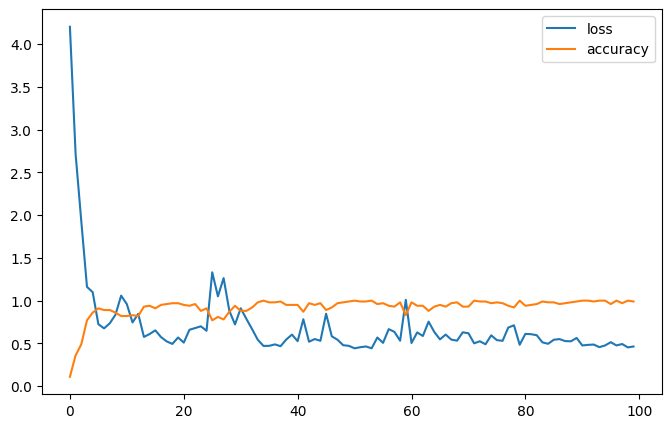

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [ ]:
score, acc = resnet18.evaluate(X_test, Y_test)
print('Test accuracy:', acc)

313/313 [==============================] - 5s 14ms/step - loss: 5.0924 - accuracy: 0.1793
Test accuracy: 0.179299995303154


(1, 32, 32, 3)


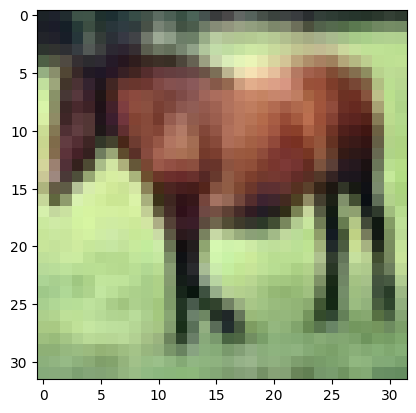

In [ ]:
from keras.preprocessing import image
import numpy as np

# Pre-processing the image
img_tensor = X_train[7]*255
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor = img_tensor / 255.

# Print image tensor shape
print(img_tensor.shape)

# Print image
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

In [ ]:
layer_outputs = [layer.output for layer in resnet18.layers[0:-2]]
activation_model = models.Model(inputs = resnet18.input, outputs = layer_outputs)
activations = activation_model.predict(img_tensor)
print(len(activations))

1/1 [==============================] - 1s 700ms/step
67


In [ ]:
for layer in resnet18.layers:
  print(layer)

In [ ]:
# for i, activation in enumerate(activations):
#   print(i, activation.shape)

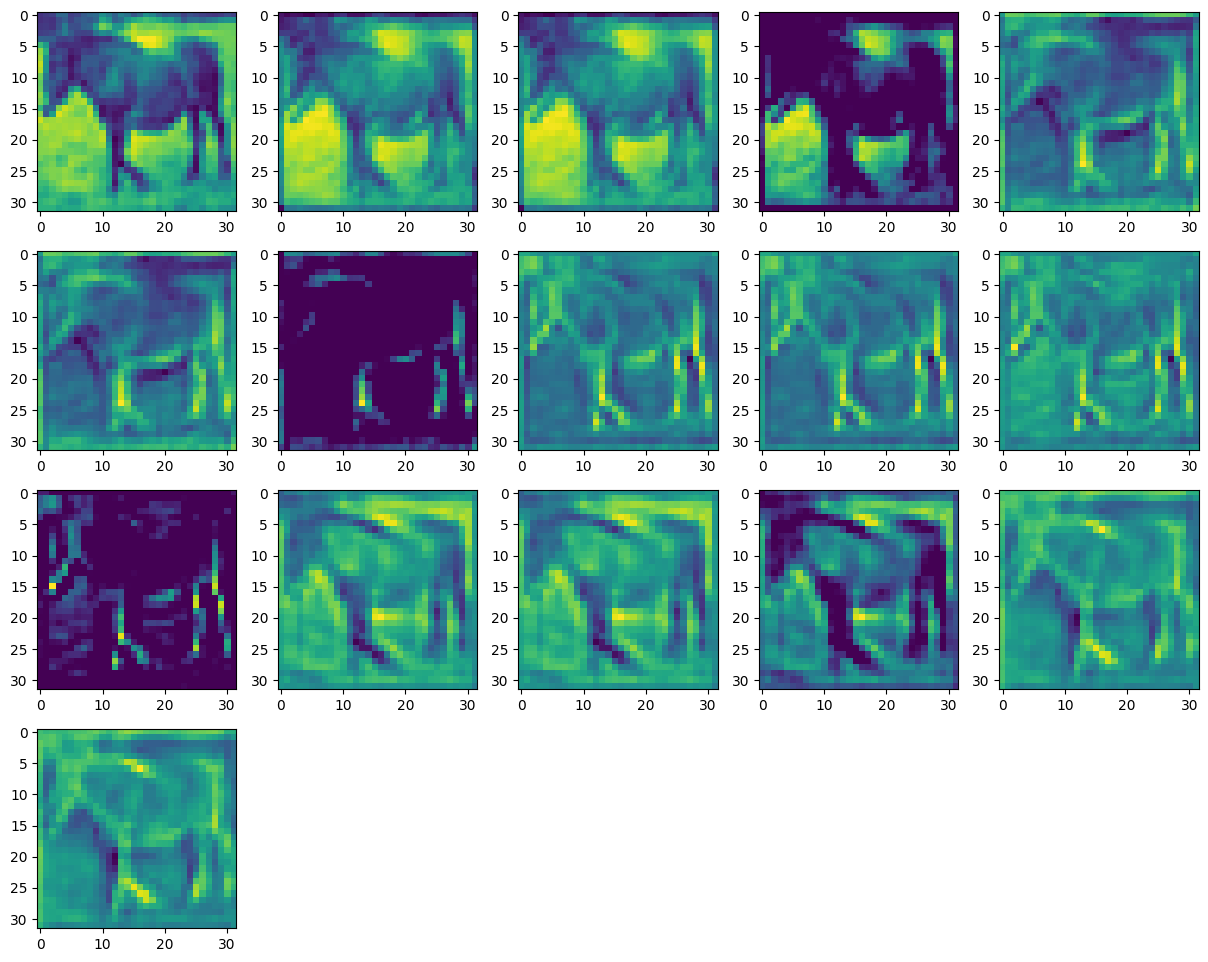

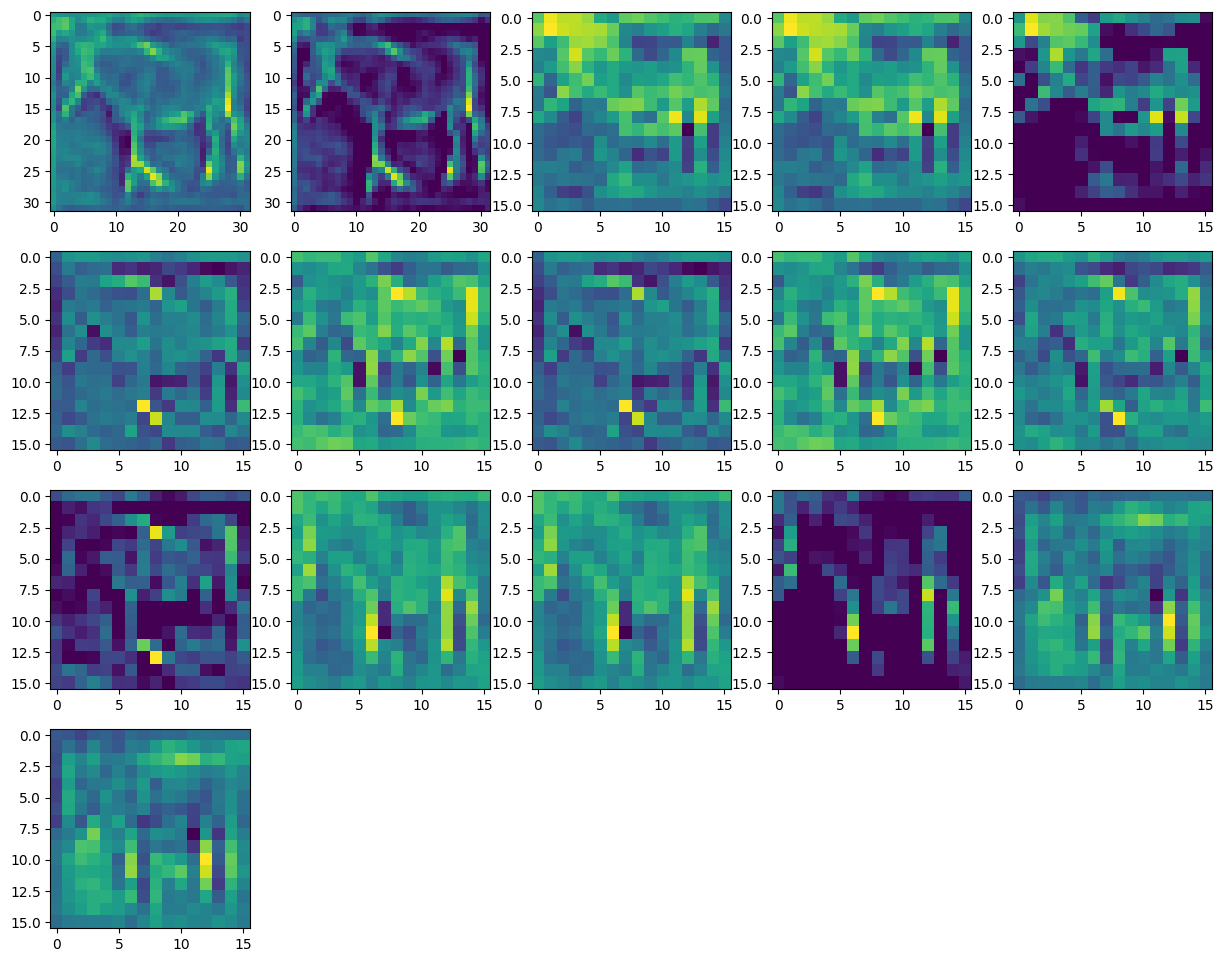

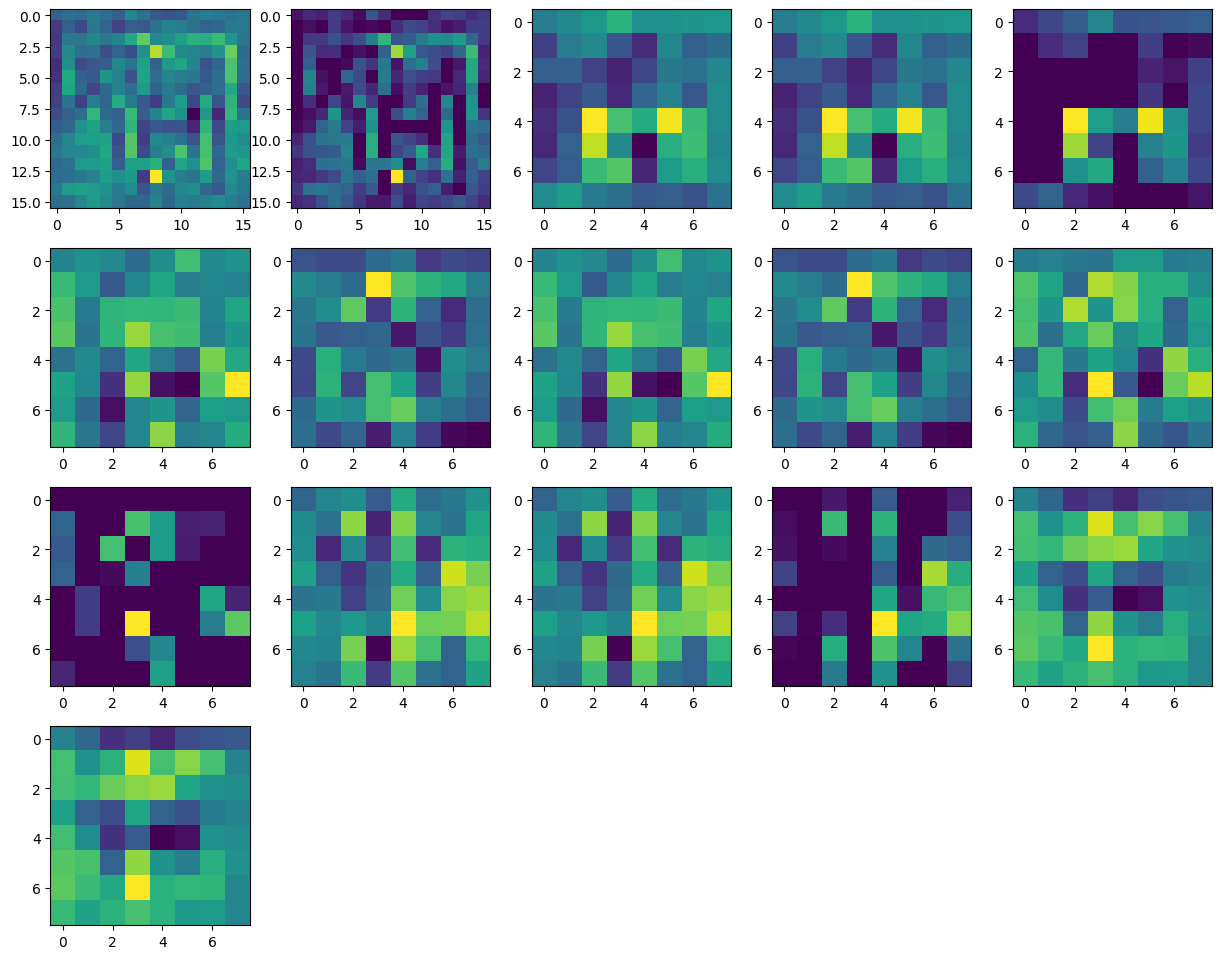

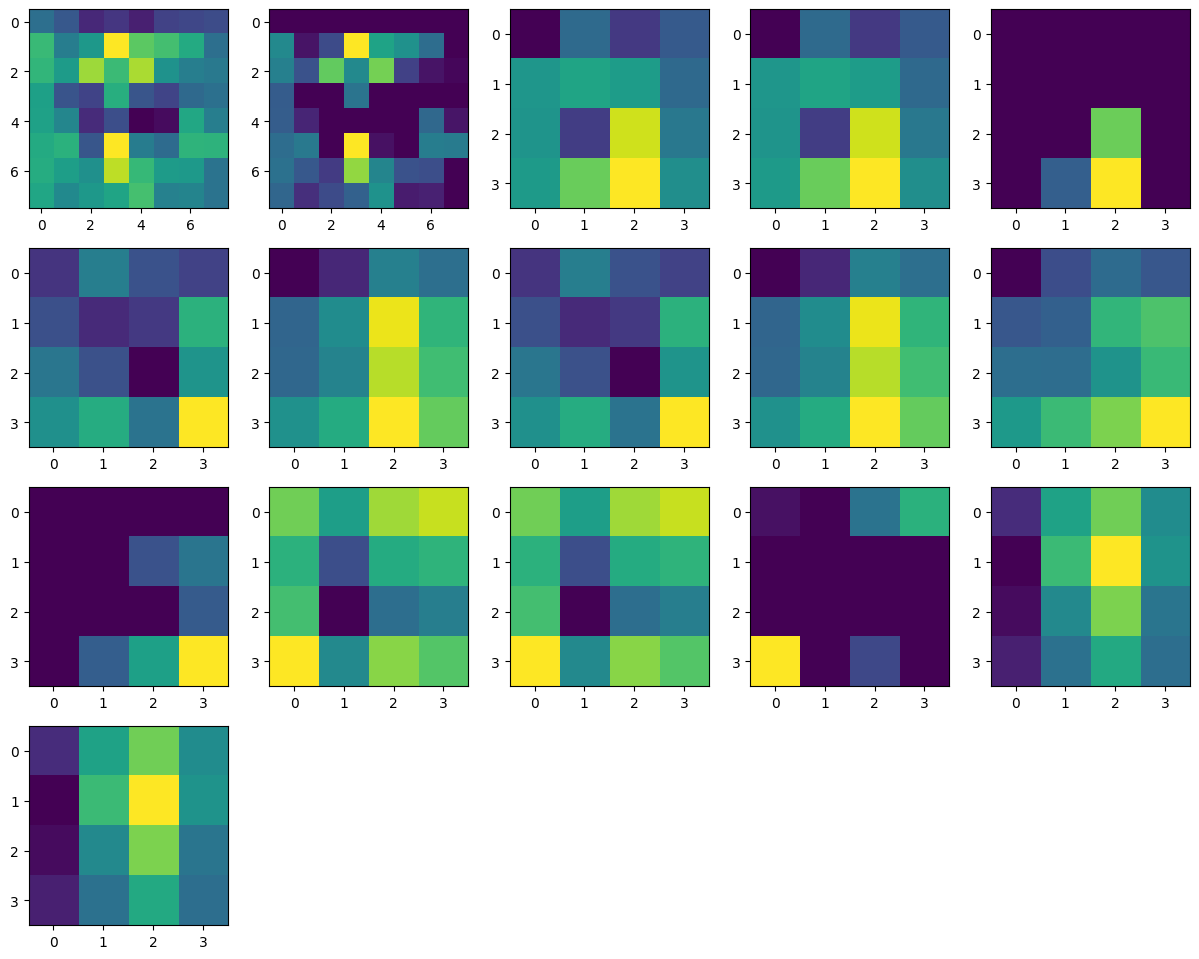

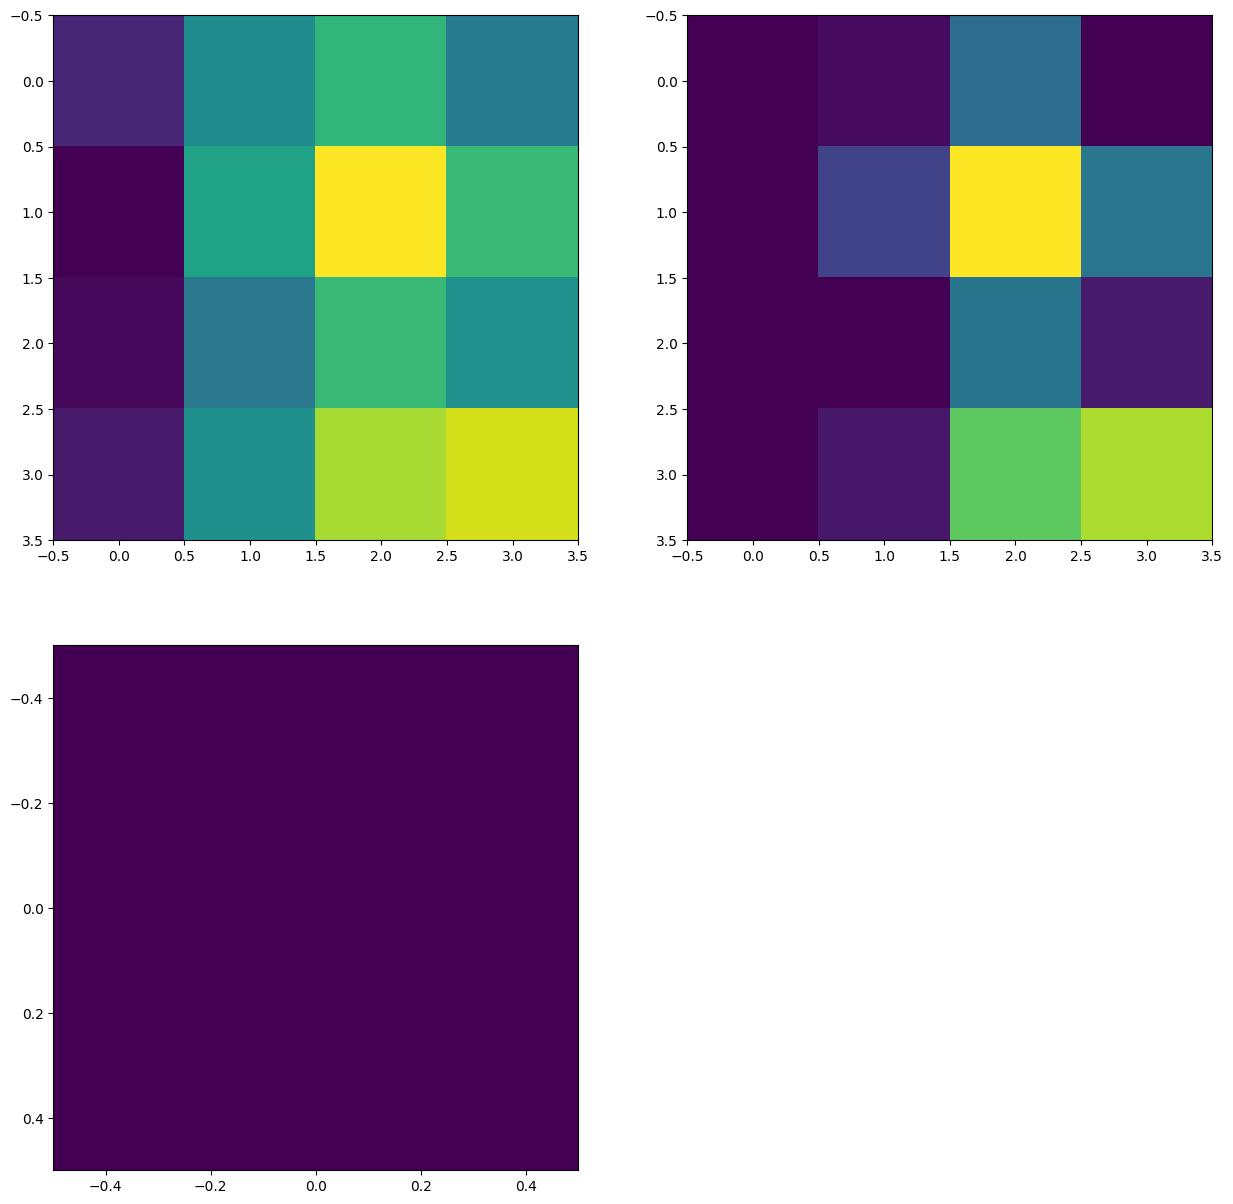

In [ ]:
temp = []
for activation in activations:
  temp.append(activation[0 ,: ,: ,-1])

batches = split_images_into_batches(temp, batch_size=16)
for batch in batches:
  plot_batch(batch)

In [ ]:
conv_kernels = [K.get_value(l.kernel) for l in resnet18.layers if isinstance(l, keras.layers.Conv2D)]

for kernel in conv_kernels:
  n1,n2,n3,n4 = kernel.shape
  for i in range(n3):
    cur_slices=[]
    for j in range(n4)

(3, 3, 64, 64)

###Visualize Weights

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

clist = [(0.1, 0.6, 1.0), (0.05, 0.05, 0.05), (0.8, 0.5, 0.1)]
bbo = LinearSegmentedColormap.from_list("custom", clist)

def restack_kernel(kernel, separator_width=0, separator_value=0.0):
    #split the tensor into 2D slices and then restack them
    stack = []

    n1, n2, n3, n4 = kernel.shape
    for i in range(n3):
        cur_slices = []
        for j in range(n4):
            cur_slices.append(kernel[:, :, i, j])
            if j != n4-1 and separator_width > 0:
                #add in a vertical separator image
                cur_slices.append(np.repeat(separator_value, n1).reshape((-1, 1)))
        row_stack = np.hstack(cur_slices)
        stack.append(row_stack)
        if i != n3-1 and separator_width > 0:
            #add a horizontal separator
            stack.append(np.repeat(separator_value, row_stack.shape[1]).reshape((1, -1)))

    stacked = np.vstack(stack)
    return stacked

def stacked_heatmaps_kernel_plot(
    kernel,
    axis_ordering=None,
    clip_percentile=99.5,
    separator_width=1,
    separator_value=0.0,
    cmap=None,
    ax=None,
    imshow_kwargs=None,
):
    #optionally reorder the axes
    if not axis_ordering is None:
        kernel = kernel.transpose(axis_ordering)

    if cmap is None:
        cmap = bbo

    if ax is None:
        fig, ax = plt.subplots()

    if imshow_kwargs is None:
        imshow_kwargs = {}

    stacked = restack_kernel(kernel, separator_width=separator_width, separator_value=separator_value)

    clip_mag = np.percentile(np.abs(stacked), clip_percentile)

    im = ax.imshow(stacked, cmap=cmap, vmin=-clip_mag, vmax=clip_mag, **imshow_kwargs)
    return im
conv_kernels = [K.get_value(l.kernel) for l in resnet18.layers if isinstance(l, keras.layers.Conv2D)]
for conv_index, kernel in enumerate(conv_kernels):
    figsize=(12, 6)
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title("Kernel for Conv {} (Spatial Slices)".format(conv_index))
    im = stacked_heatmaps_kernel_plot(kernel, ax=ax)
    plt.colorbar(im, fraction=0.015)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.tight_layout()
    # if conv_index == 1:
    #     #save the second image out as the teaser image for this post
    #     fig.savefig("../images/visualizing_convolution_kernels_teaser.png")
    plt.show()

###Resnet50

In [ ]:
model = tf.keras.applications.ResNet50(input_shape=(32,32,3), weights=None,classes=10)

In [ ]:
# model = ResNet18(10)
model.build(input_shape = (None,32,32,3))
#use categorical_crossentropy since the label is one-hot encoded
from keras.optimizers import SGD
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
model.compile(
    optimizer = "adam",
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [ ]:
history_50= model.fit(X_train,Y_train, epochs=50)

Epoch 1/50
4/4 [==============================] - 41s 54ms/step - loss: 1.8804 - accuracy: 0.7200
Epoch 2/50
4/4 [==============================] - 0s 48ms/step - loss: 2.7291 - accuracy: 0.5400
Epoch 3/50
4/4 [==============================] - 0s 42ms/step - loss: 1.6885 - accuracy: 0.5500
Epoch 4/50
4/4 [==============================] - 0s 44ms/step - loss: 1.3334 - accuracy: 0.5900
Epoch 5/50
4/4 [==============================] - 0s 42ms/step - loss: 2.0163 - accuracy: 0.5300
Epoch 6/50
4/4 [==============================] - 0s 41ms/step - loss: 1.3873 - accuracy: 0.5600
Epoch 7/50
4/4 [==============================] - 0s 44ms/step - loss: 1.0789 - accuracy: 0.7100
Epoch 8/50
4/4 [==============================] - 0s 43ms/step - loss: 0.8065 - accuracy: 0.7400
Epoch 9/50
4/4 [==============================] - 0s 45ms/step - loss: 0.6934 - accuracy: 0.8800
Epoch 10/50
4/4 [==============================] - 0s 41ms/step - loss: 0.4185 - accuracy: 0.9300
Epoch 11/50
4/4 [===========

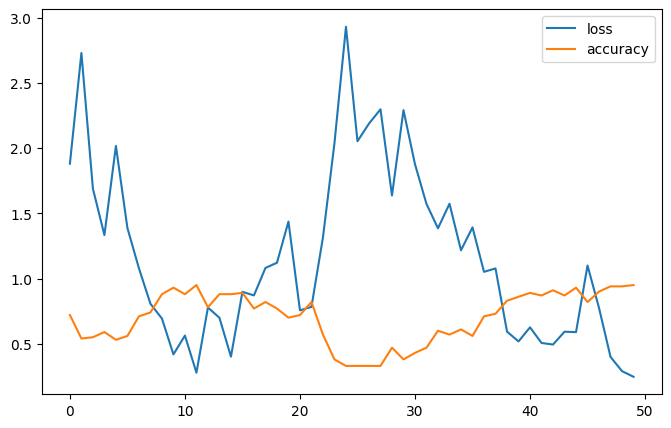

In [ ]:
pd.DataFrame(history_50.history).plot(figsize=(8,5))
plt.show()

In [ ]:
score, acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', acc)

313/313 [==============================] - 3s 11ms/step - loss: 131.5880 - accuracy: 0.1774
Test accuracy: 0.17739999294281006


(1, 32, 32, 3)


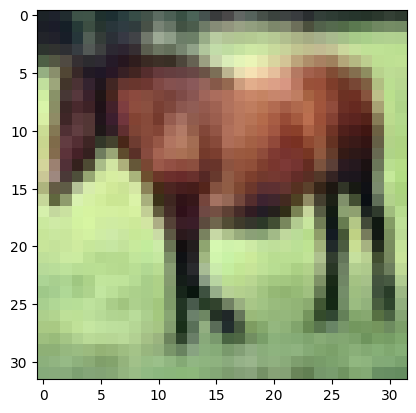

In [ ]:
from keras.preprocessing import image
import numpy as np

# Pre-processing the image
img_tensor = X_train[7]*255
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor = img_tensor / 255.

# Print image tensor shape
print(img_tensor.shape)

# Print image
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

In [ ]:
layer_outputs = [layer.output for layer in model.layers[0:-2]]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
activations = activation_model.predict(img_tensor)
len(activations)

1/1 [==============================] - 2s 2s/step


175

1/1 [==============================] - 2s 2s/step


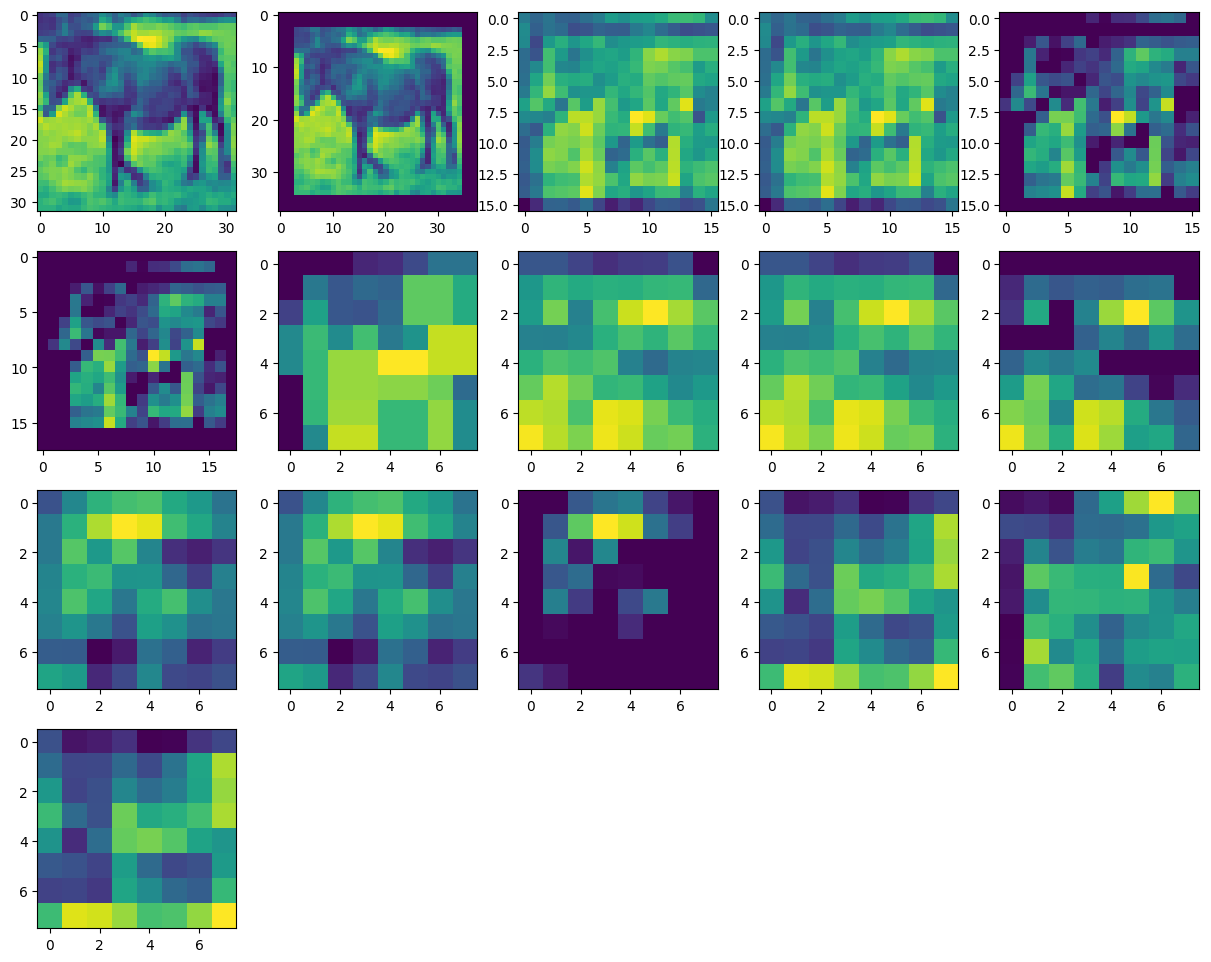

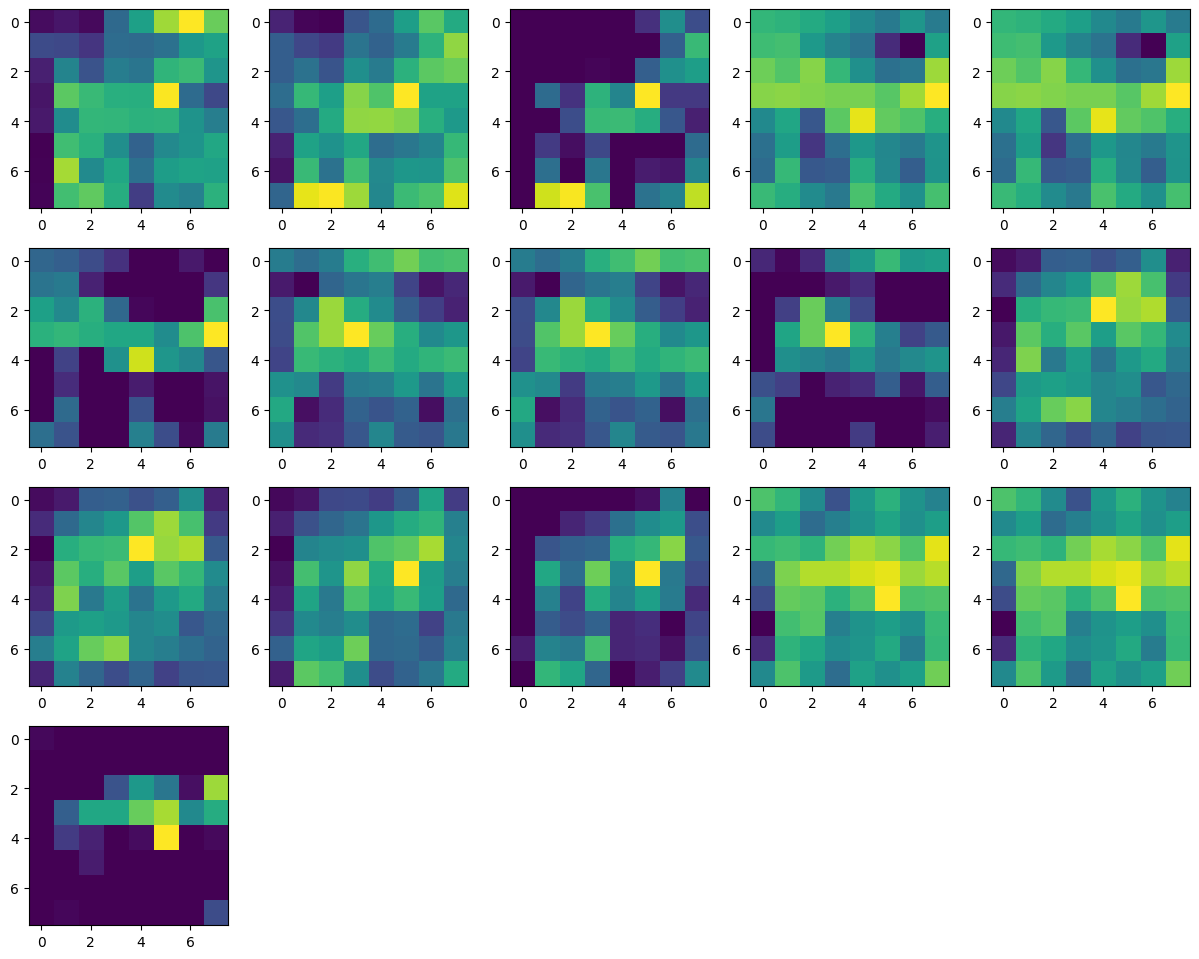

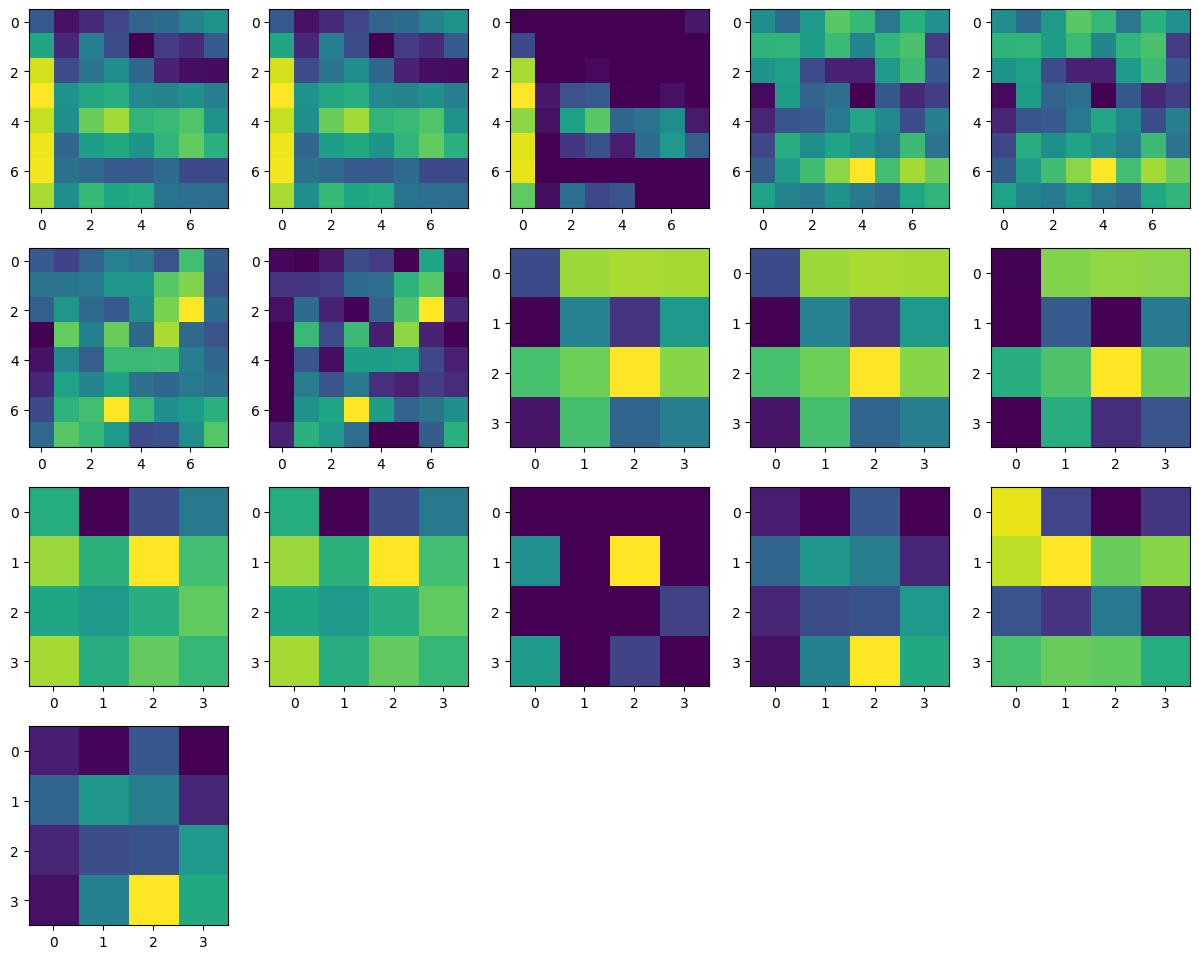

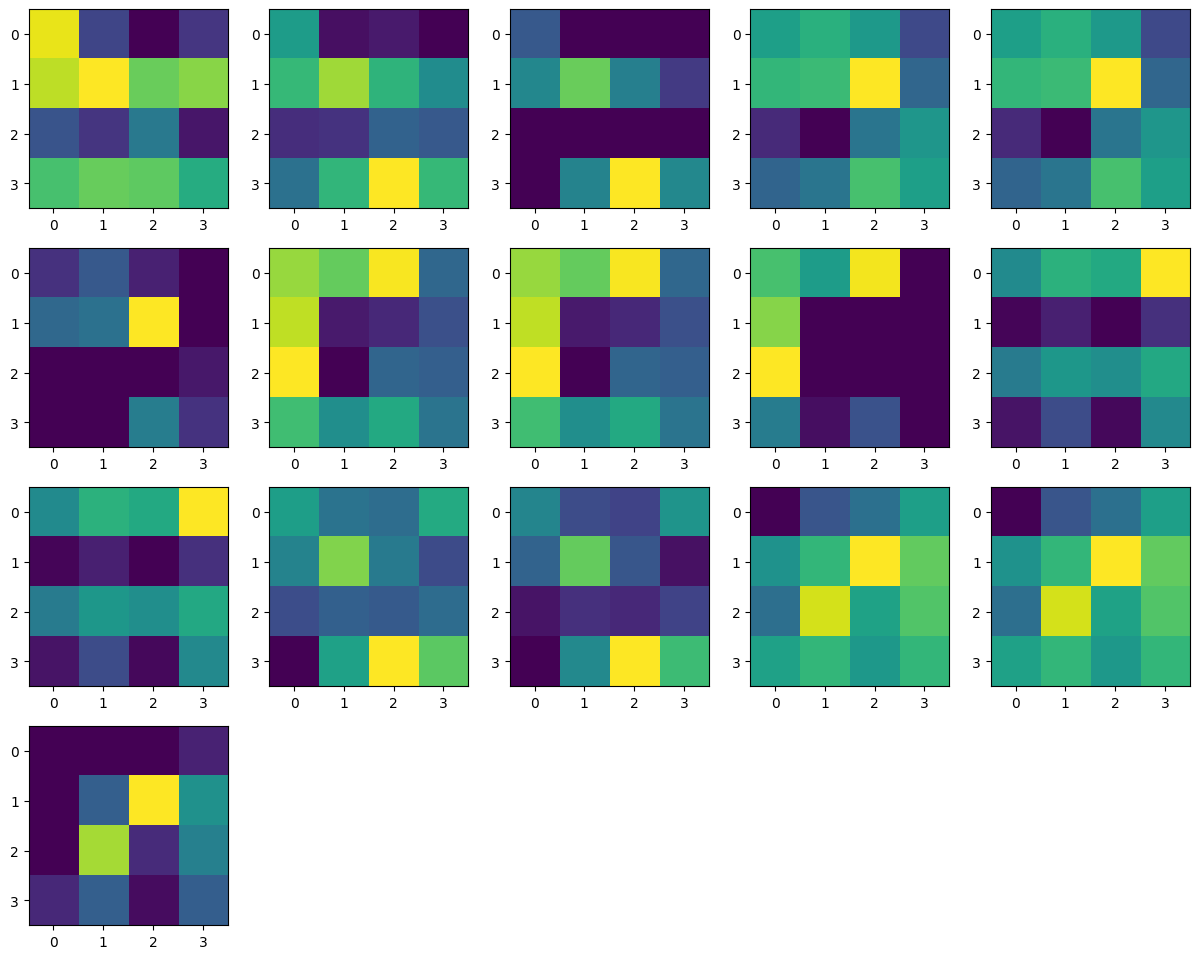

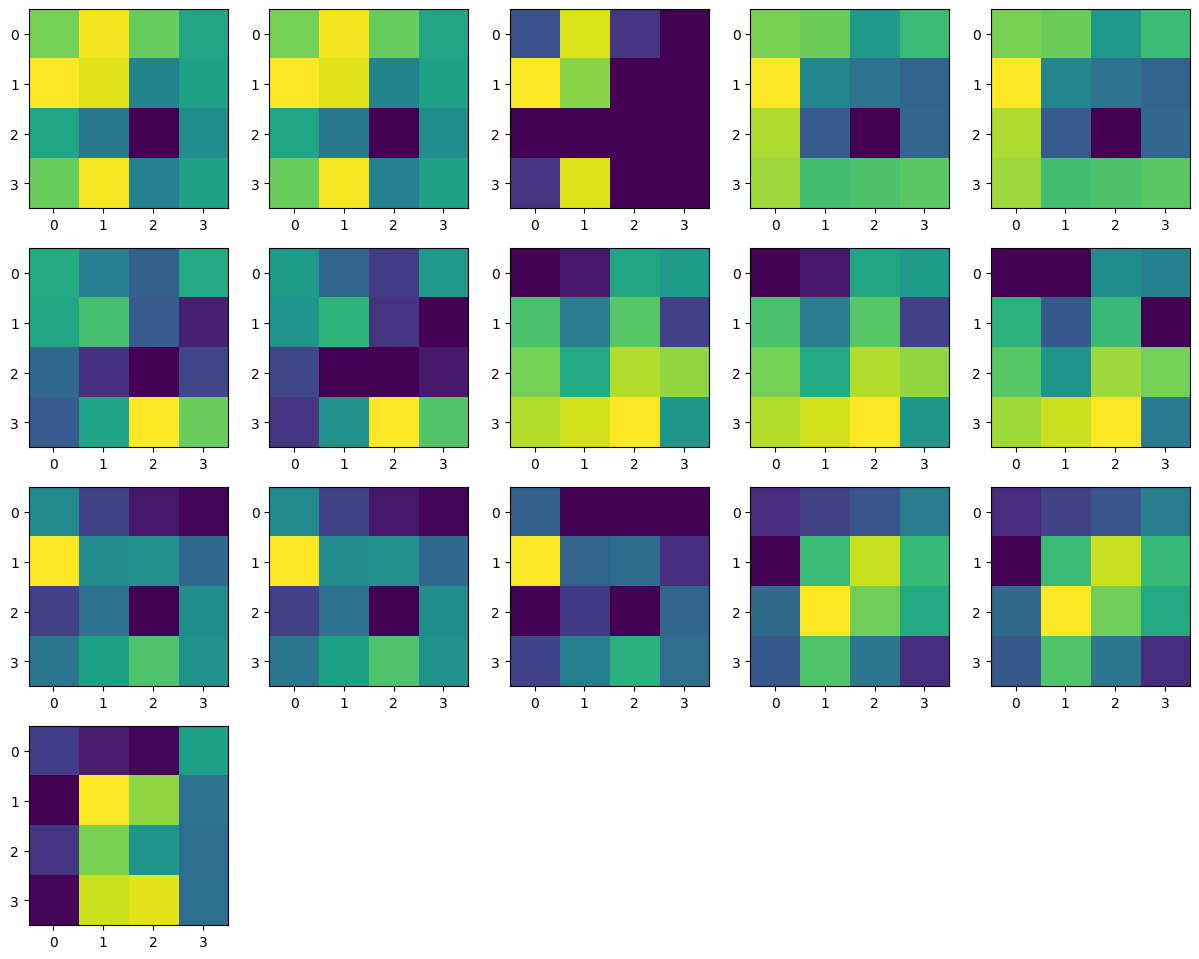

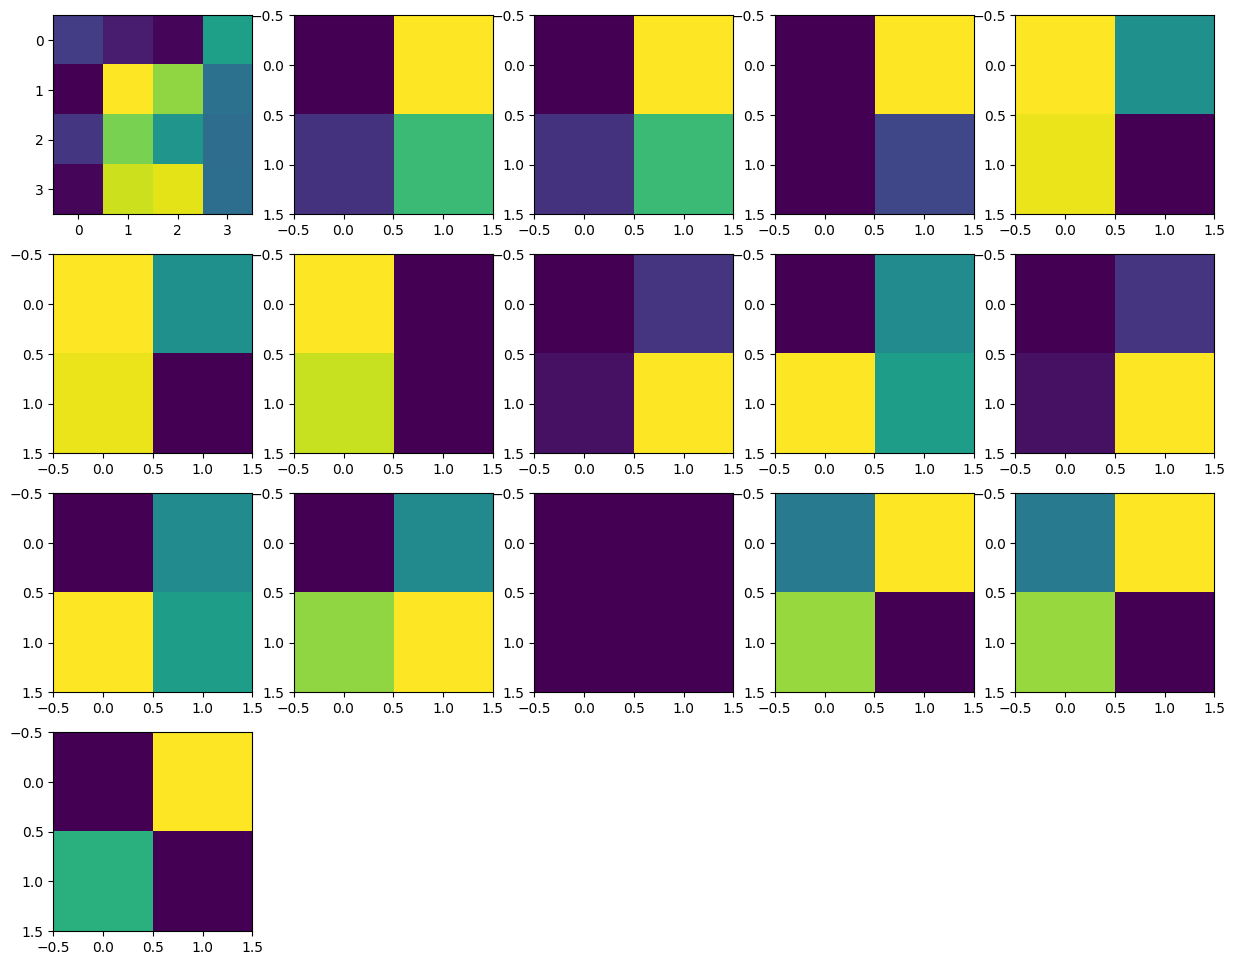

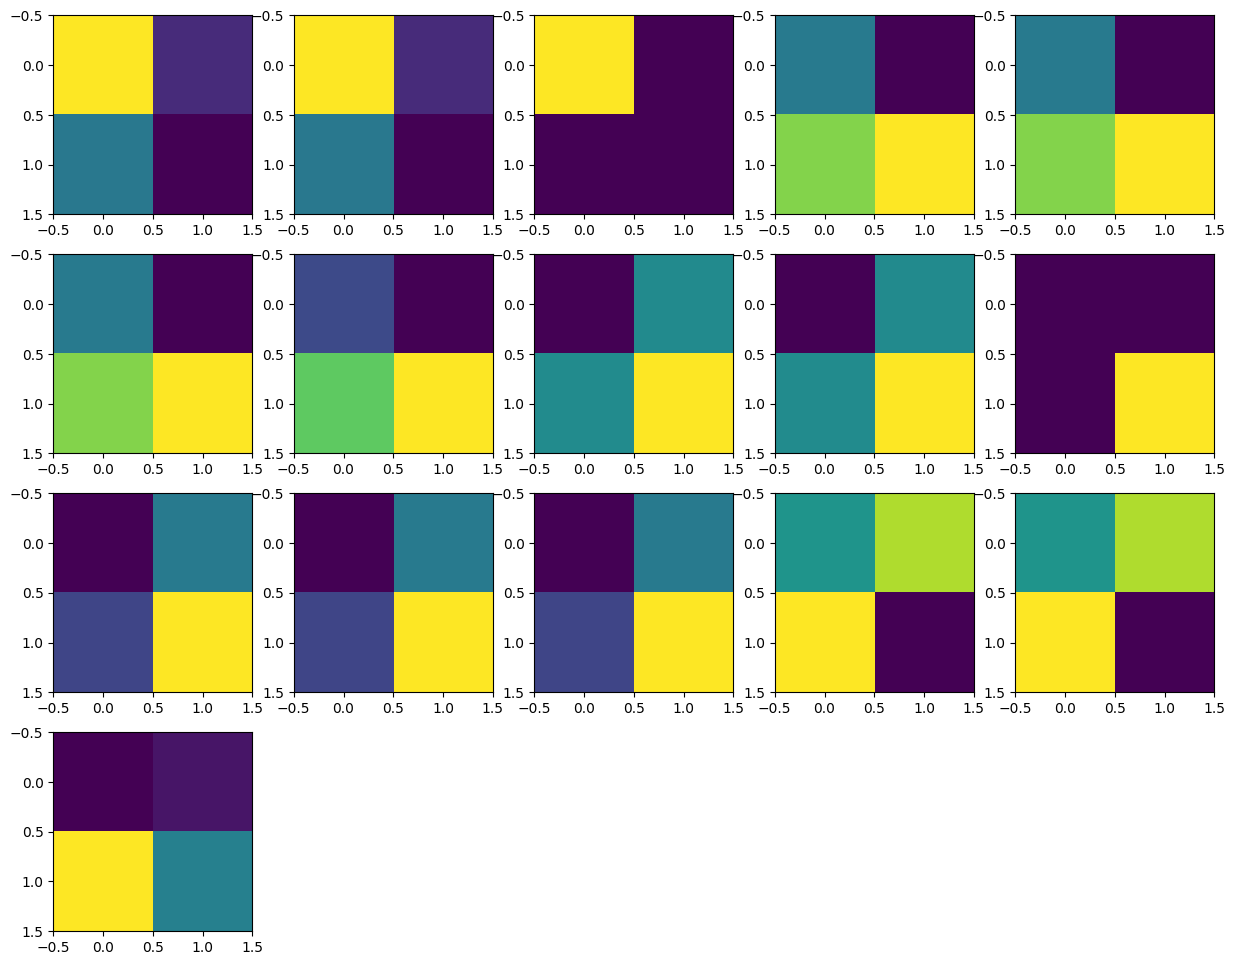

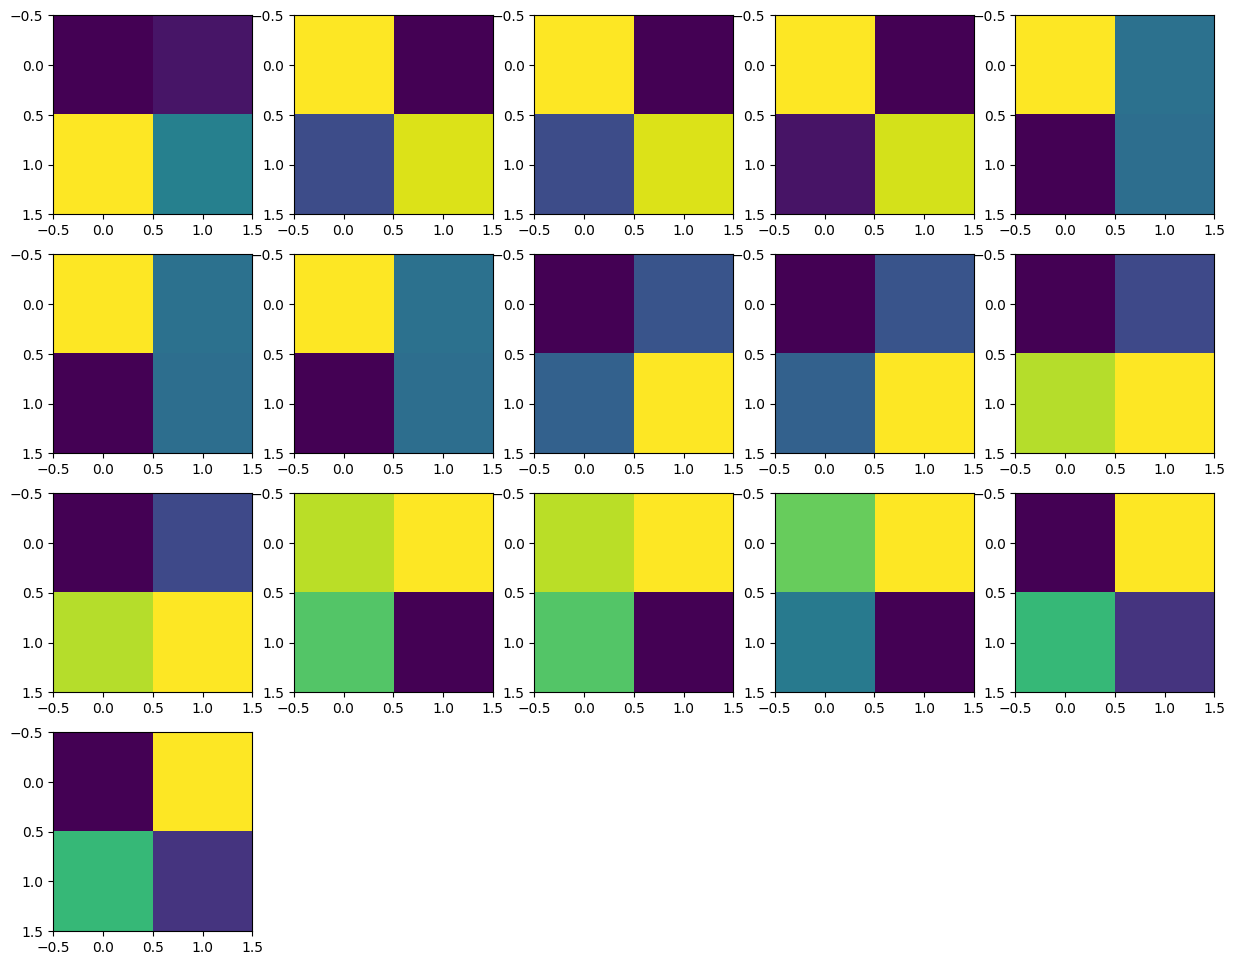

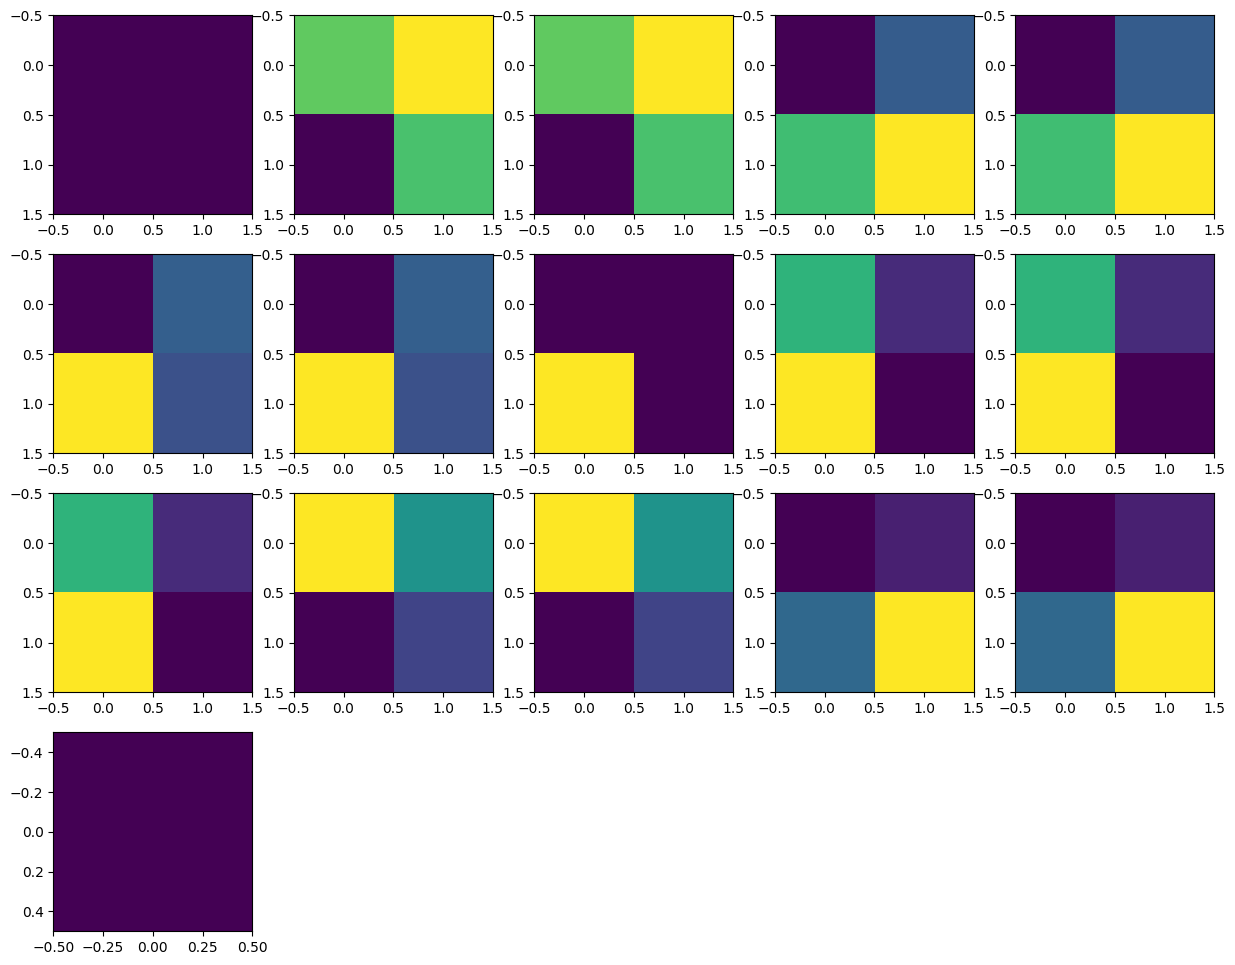

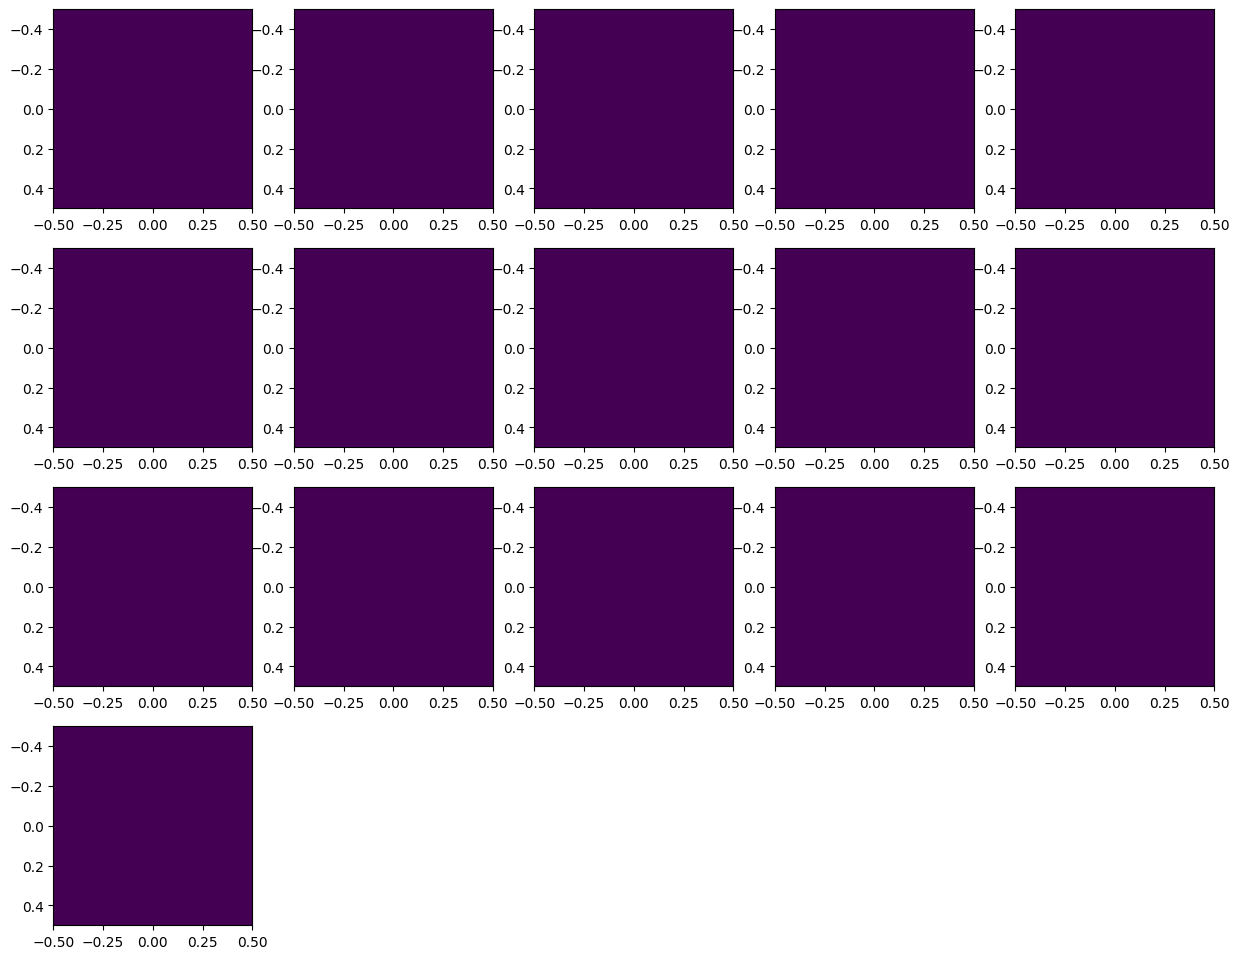

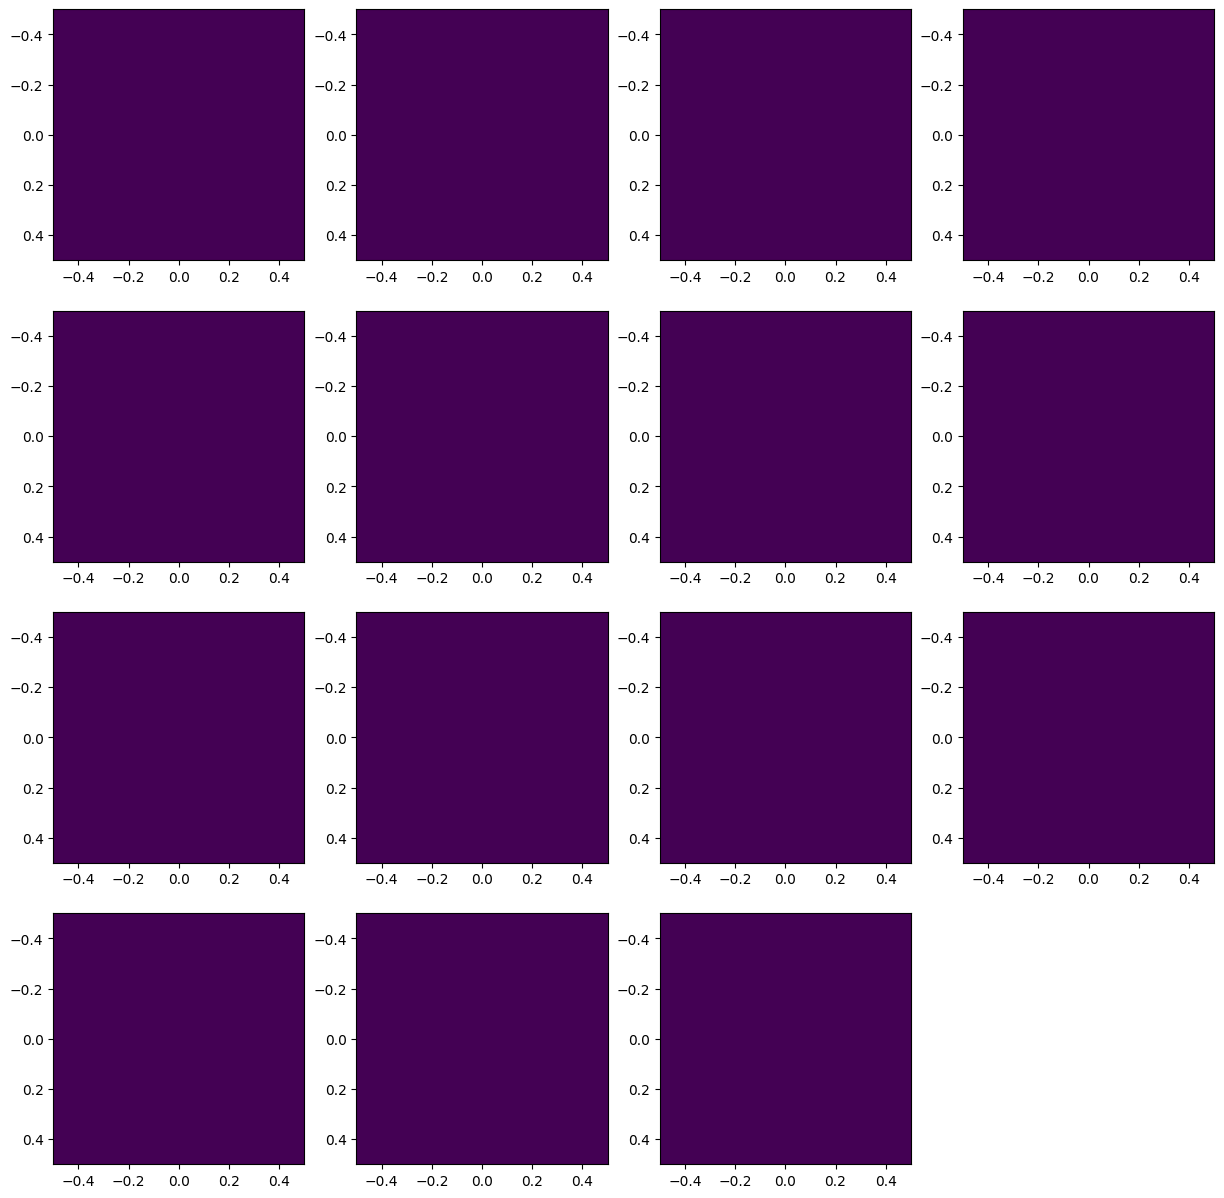

In [ ]:
layer_outputs = [layer.output for layer in model.layers[0:-2]]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
activations = activation_model.predict(img_tensor)
temp = []
for activation in activations:
  temp.append(activation[0 ,: ,: ,-1])

batches = split_images_into_batches(temp, batch_size=16)
for batch in batches:
  plot_batch(batch)

1 (1, 32, 32, 3)
2 (1, 38, 38, 3)
3 (1, 16, 16, 64)
4 (1, 16, 16, 64)
5 (1, 16, 16, 64)


<ipython-input-187-70cd85f2e9dc>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.matshow(pl, cmap ='viridis')


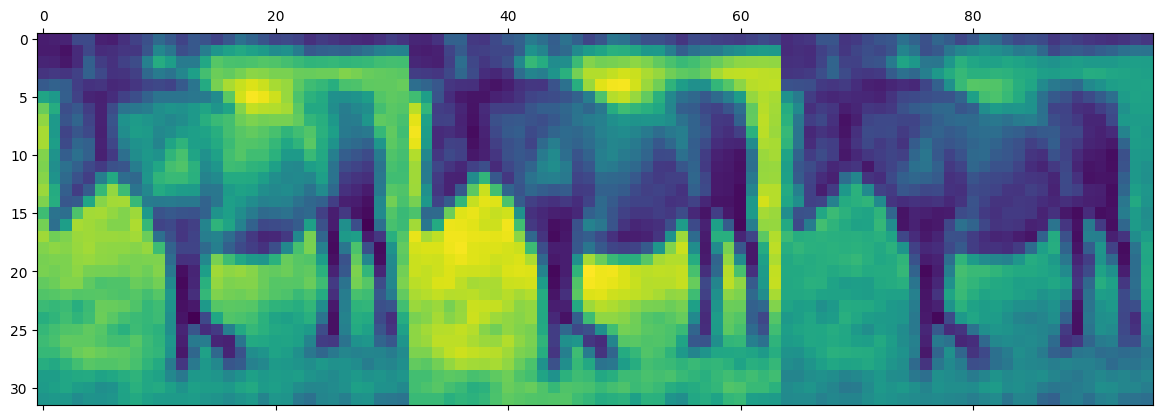

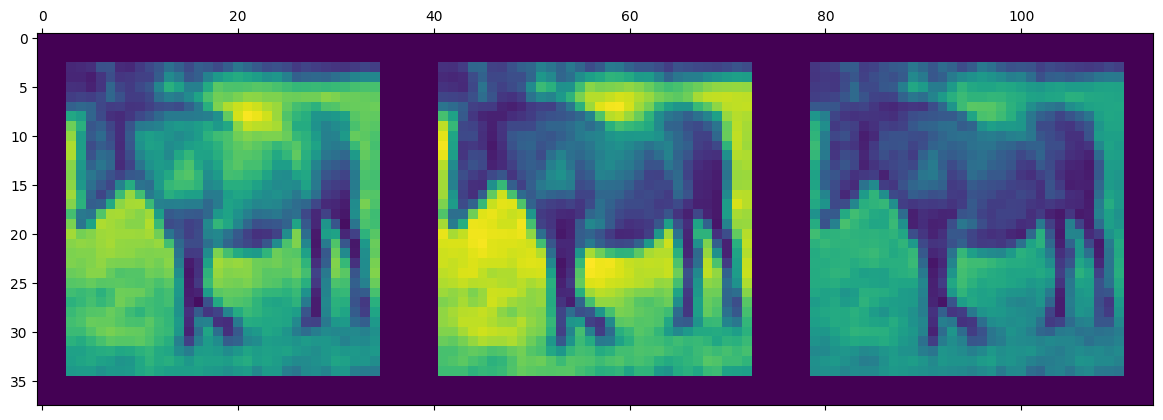

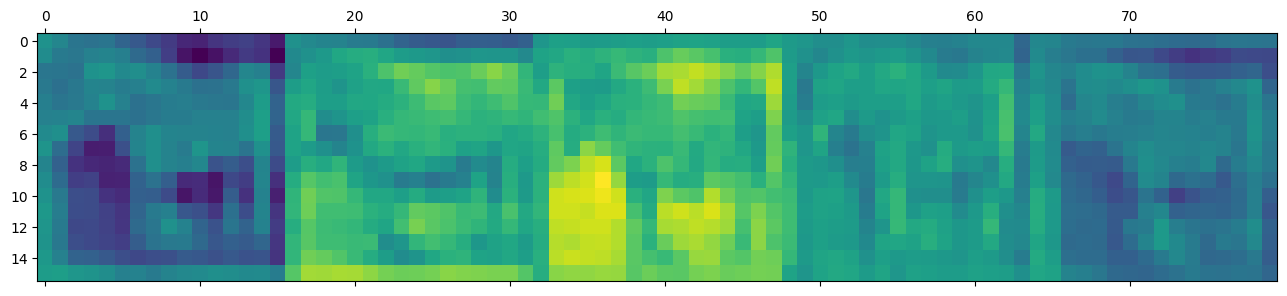

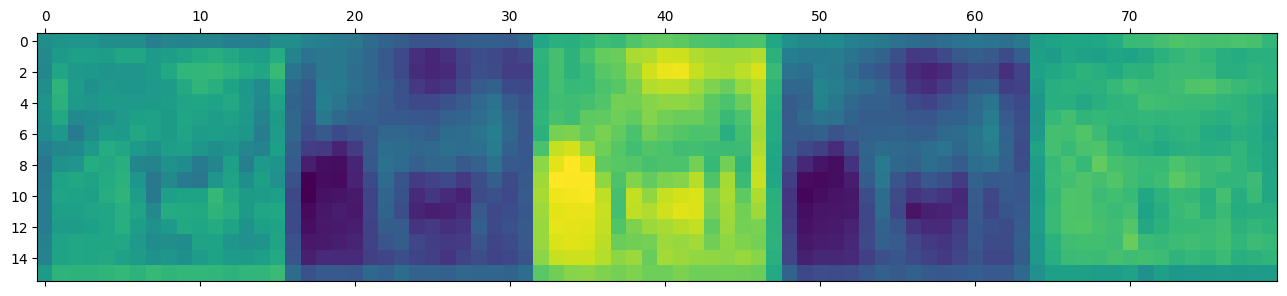

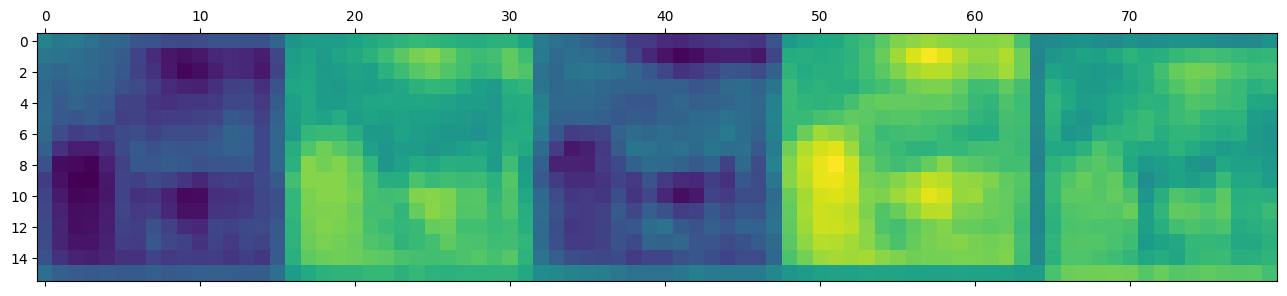

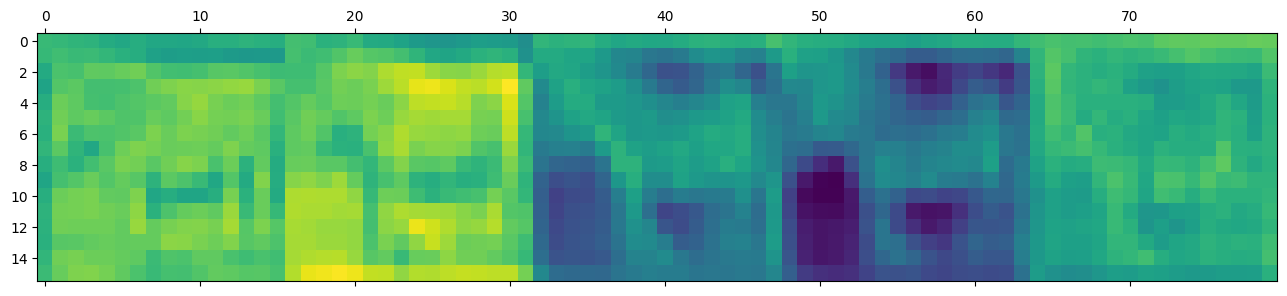

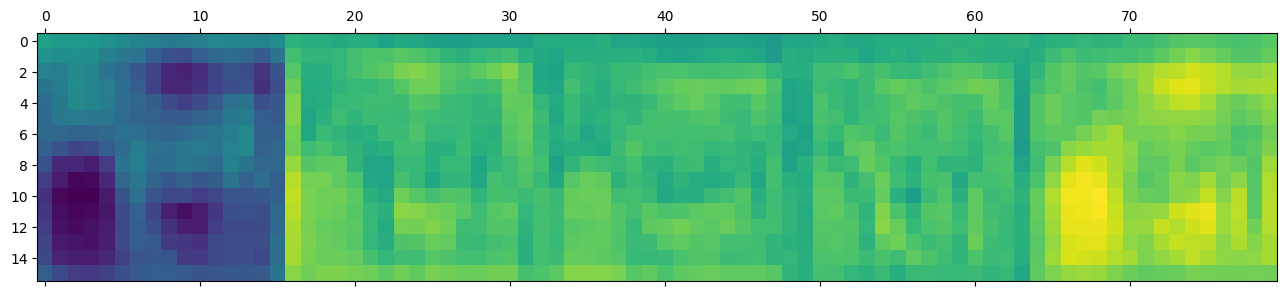

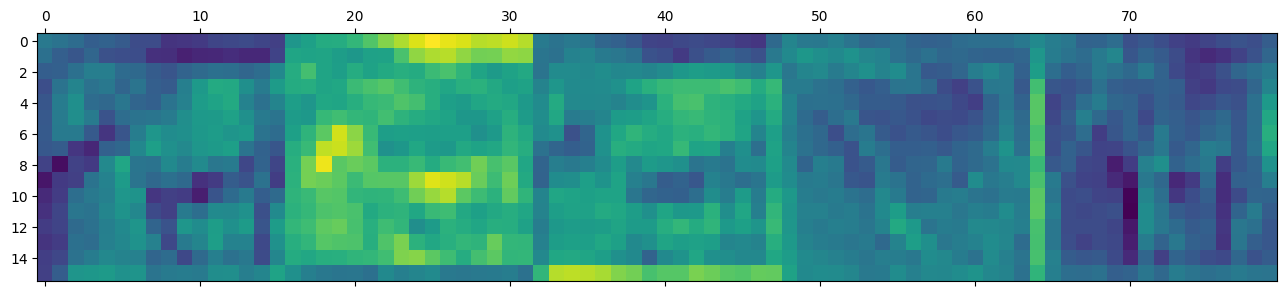

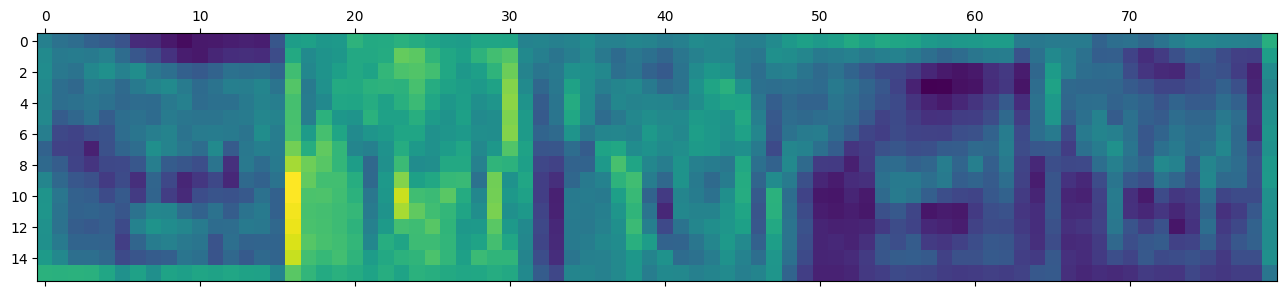

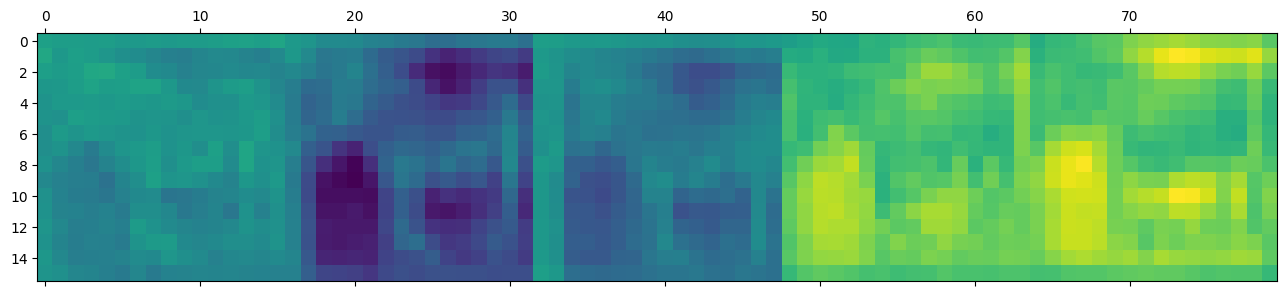

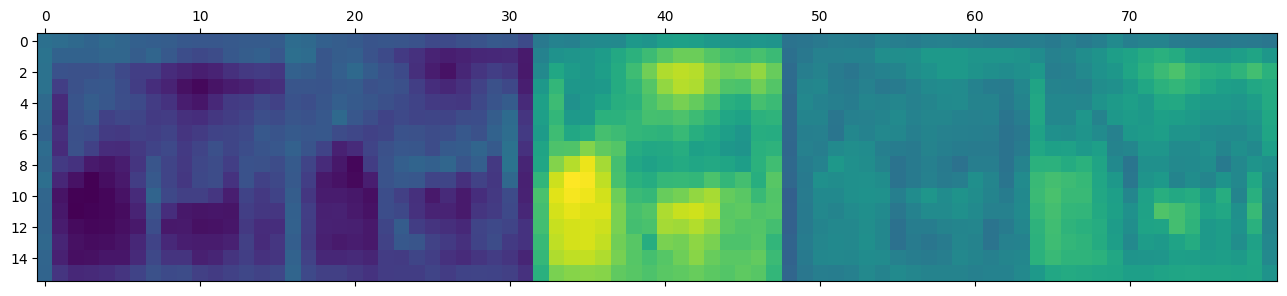

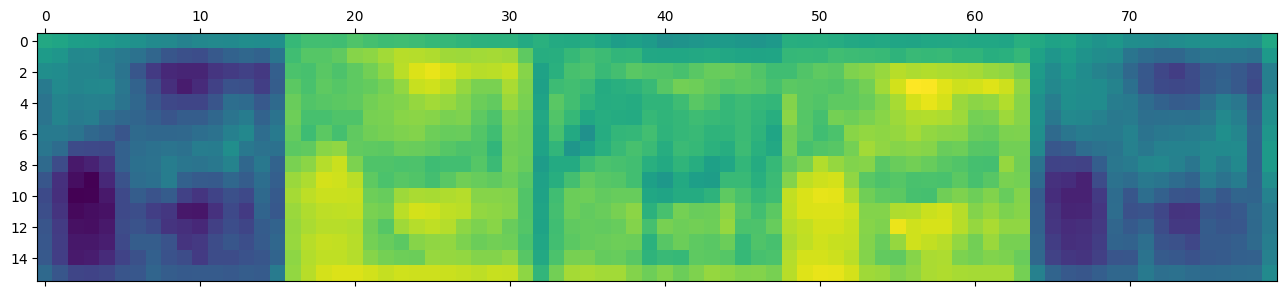

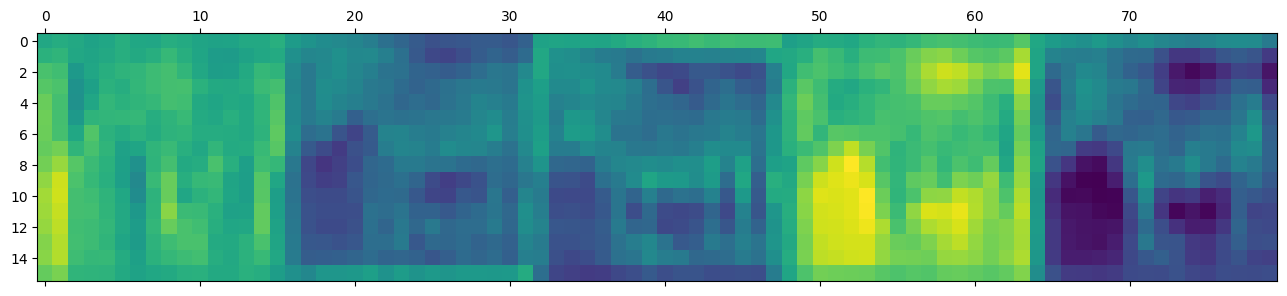

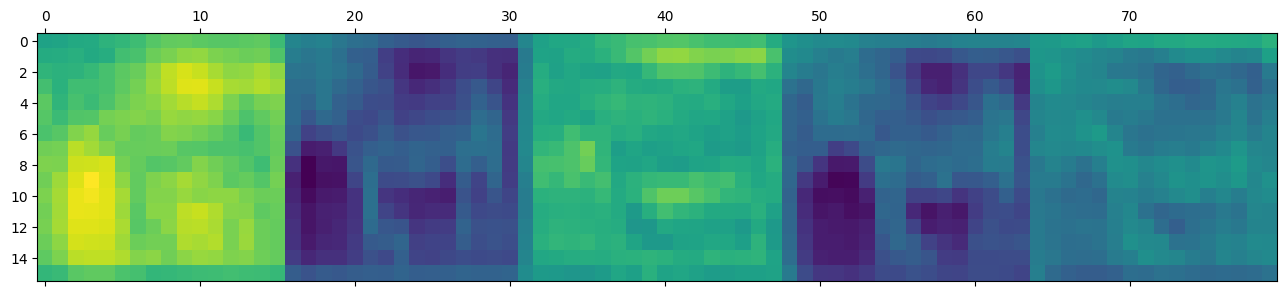

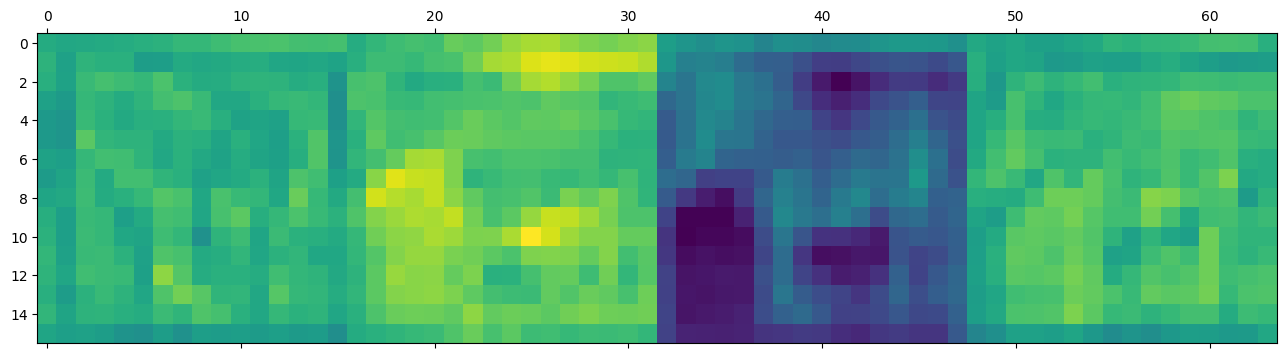

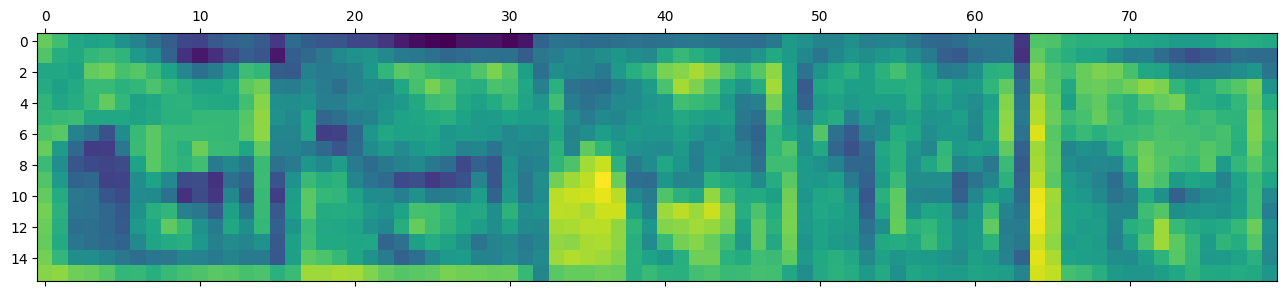

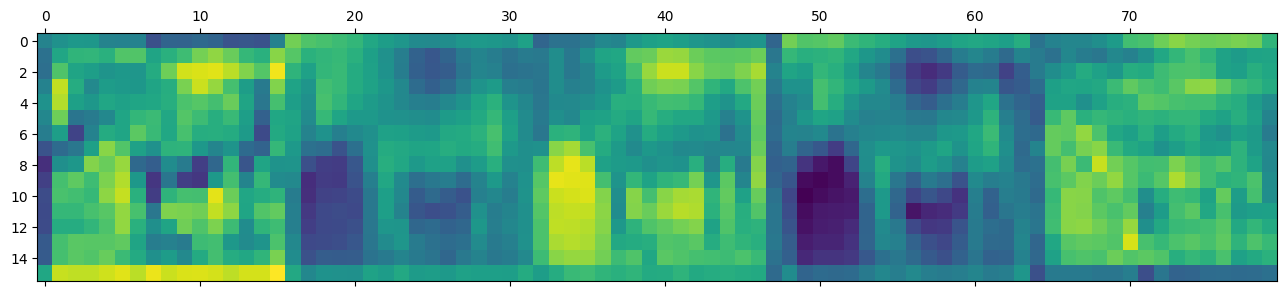

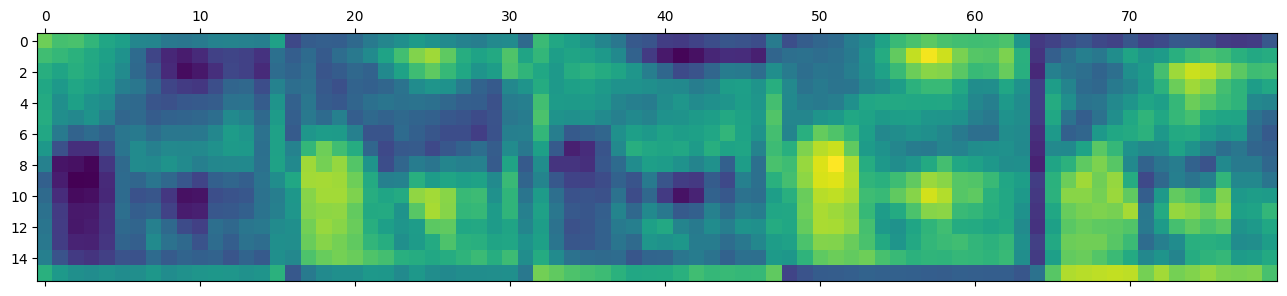

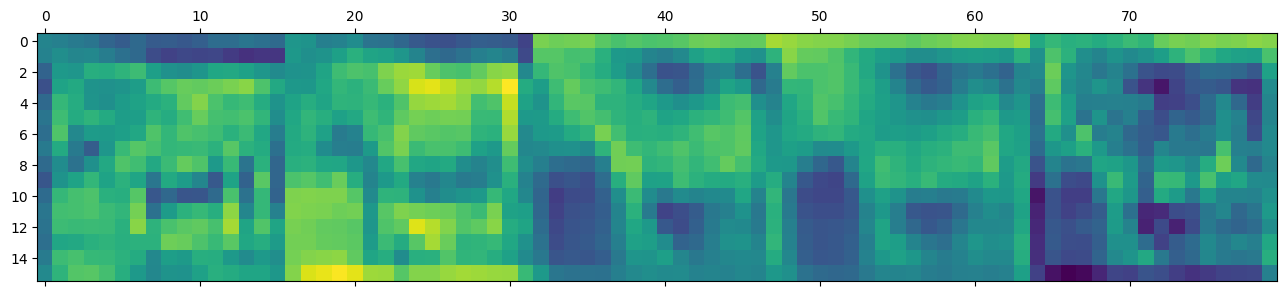

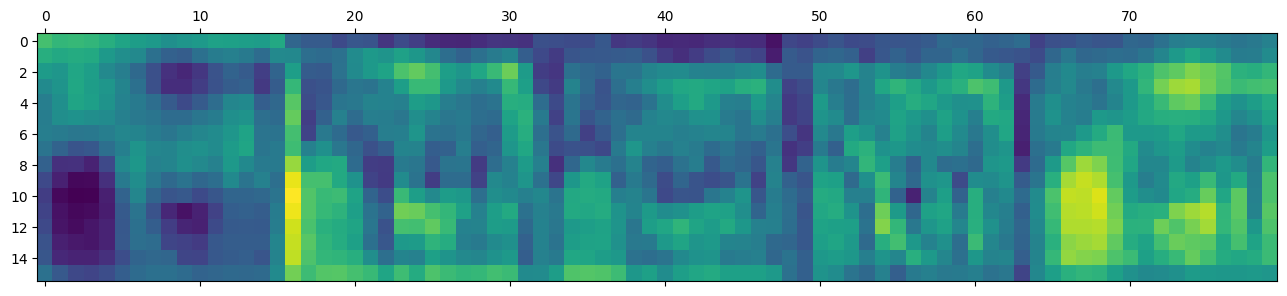

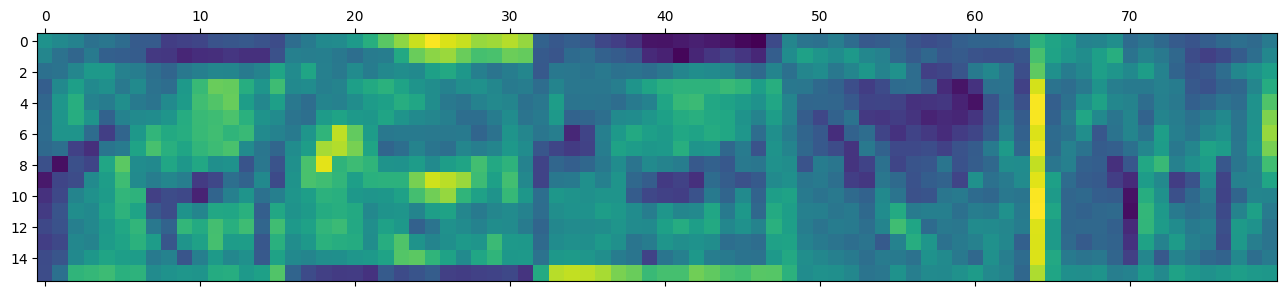

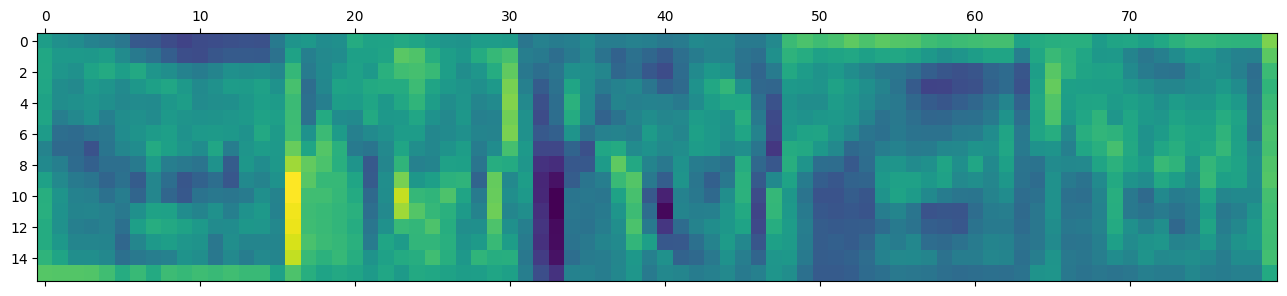

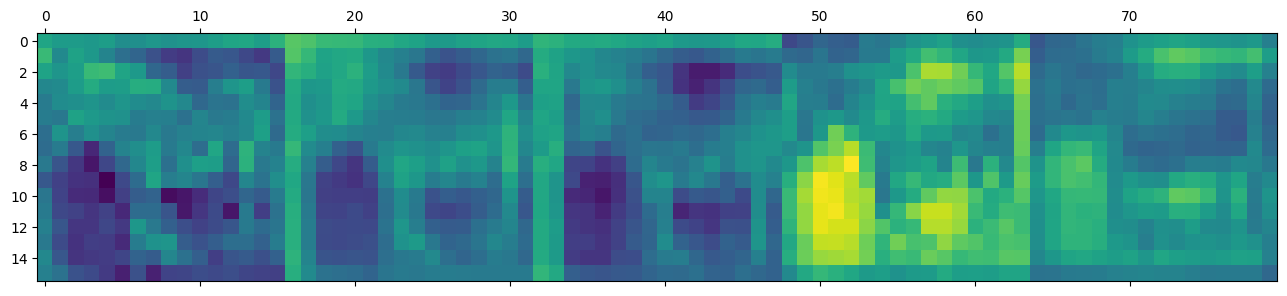

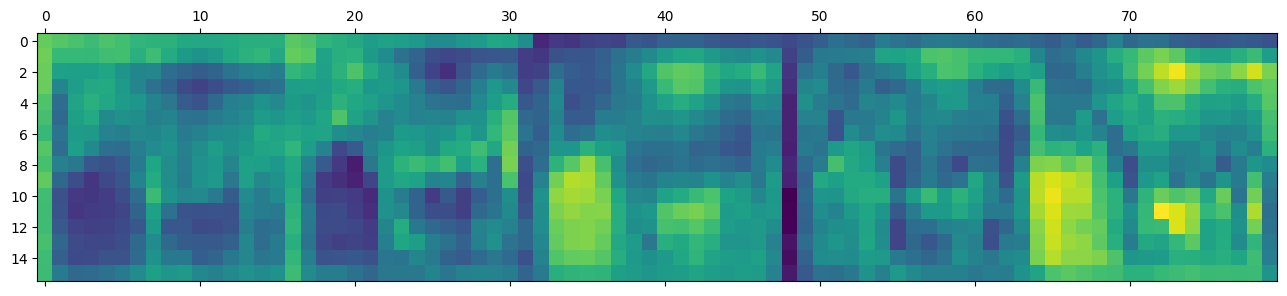

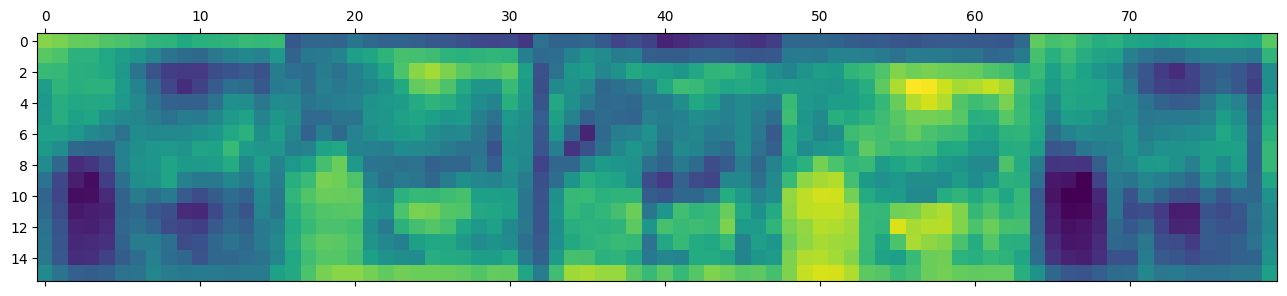

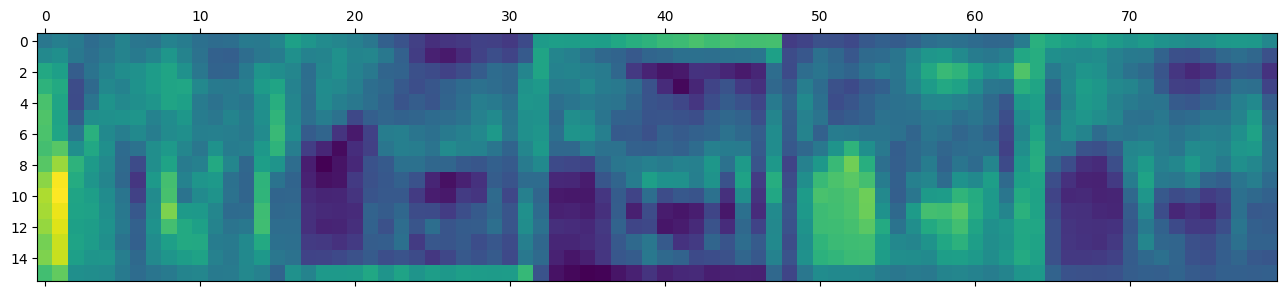

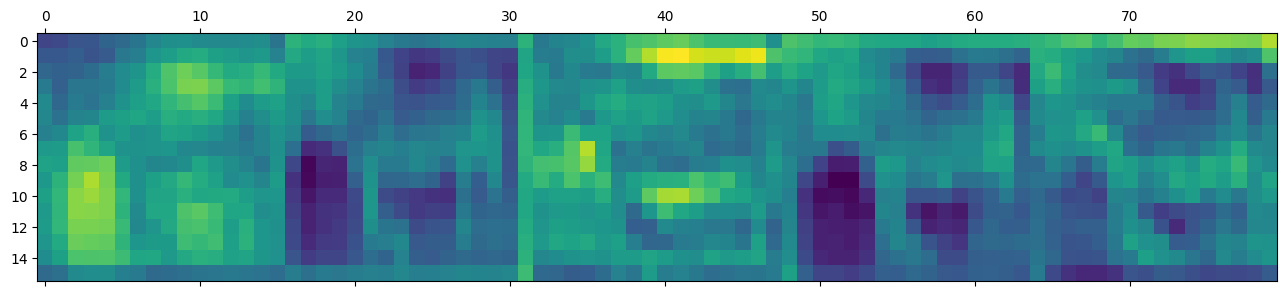

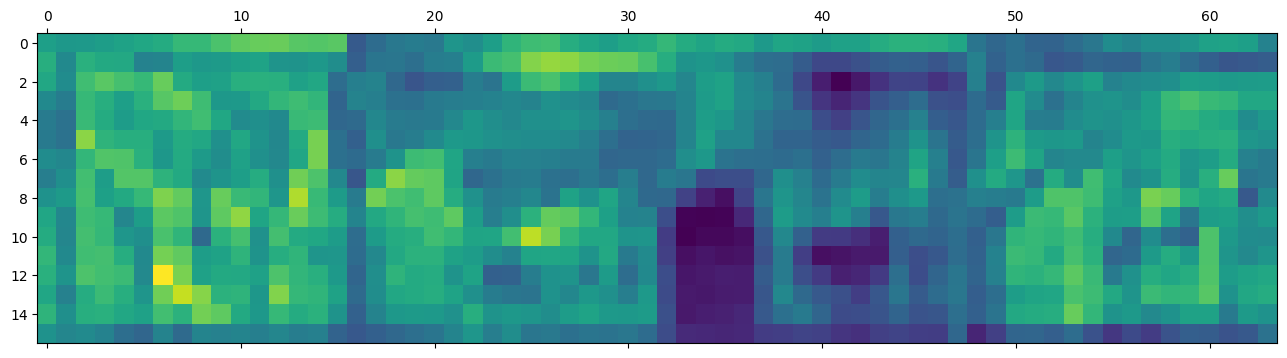

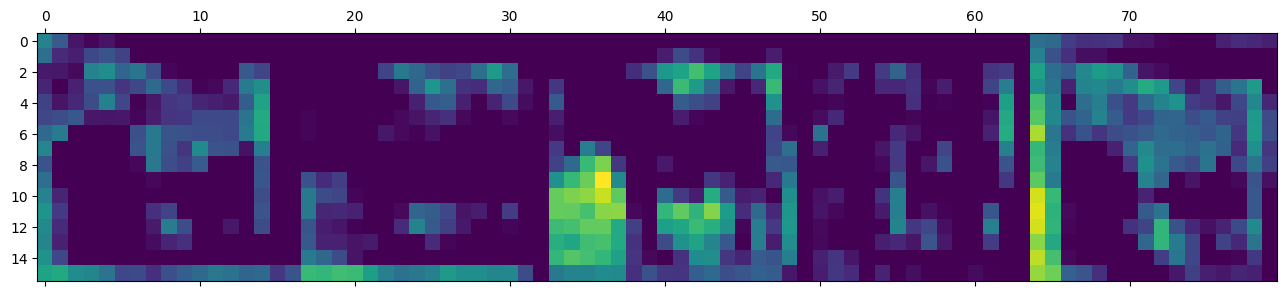

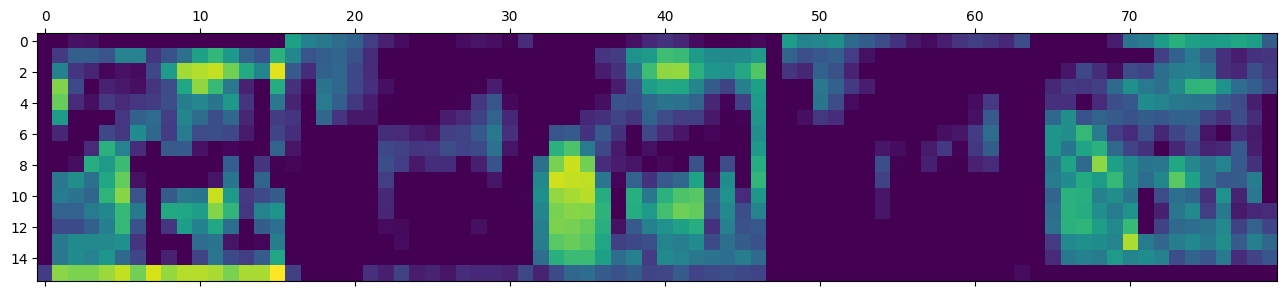

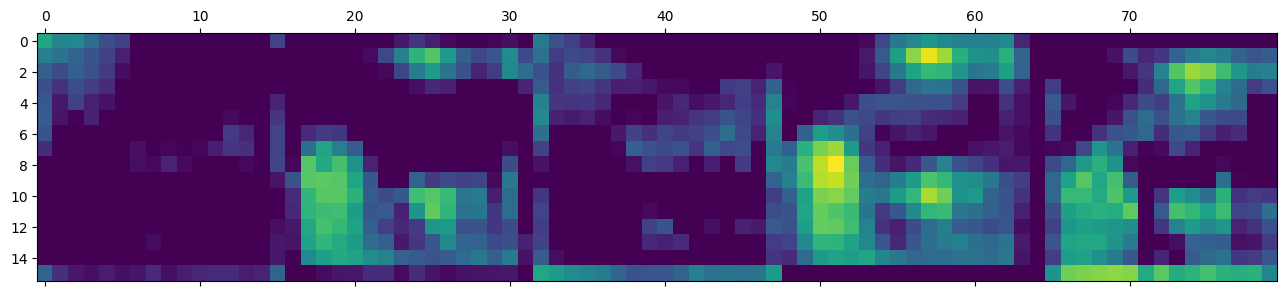

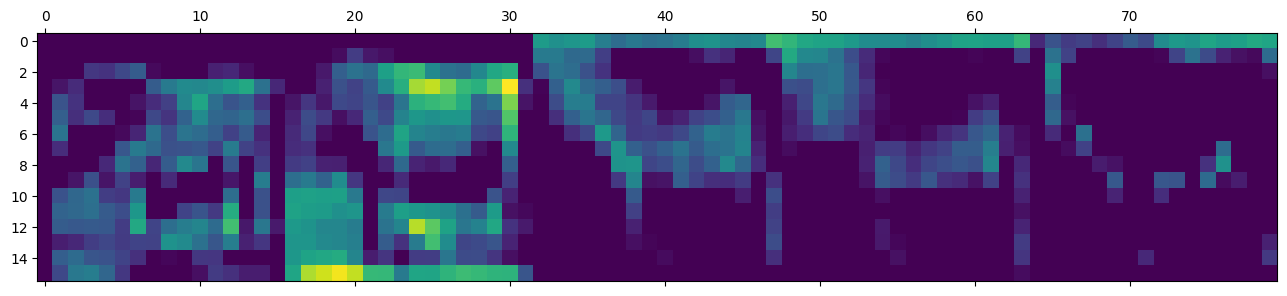

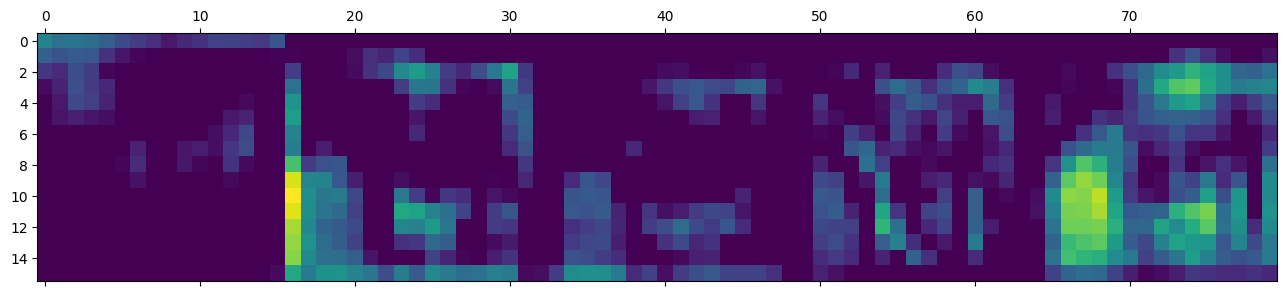

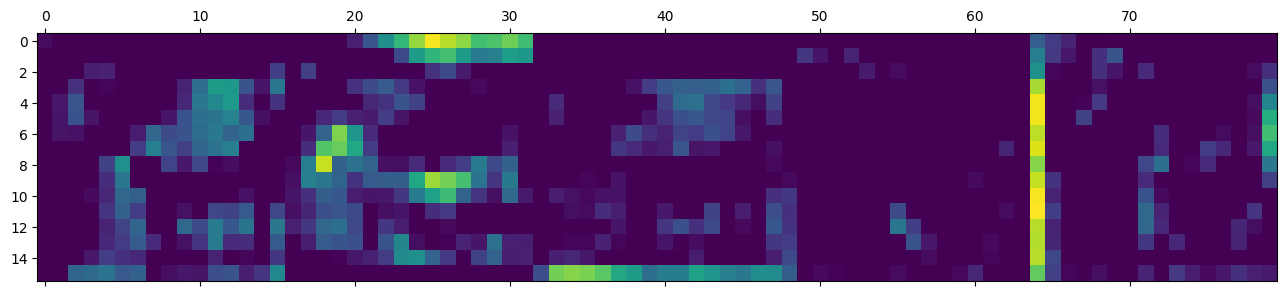

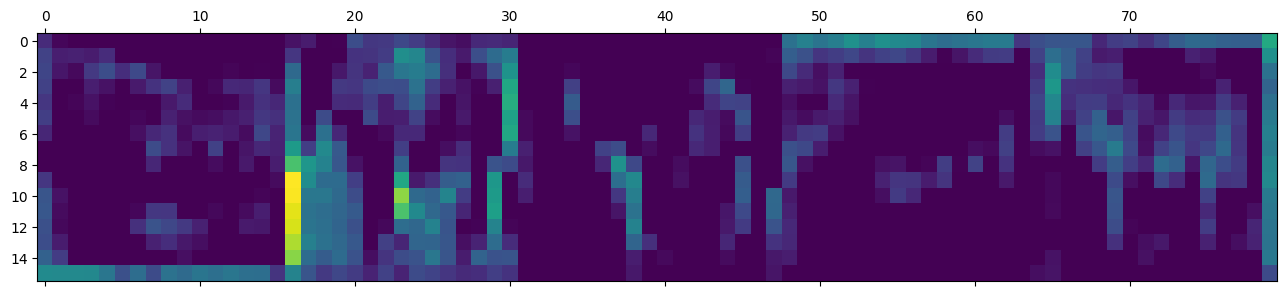

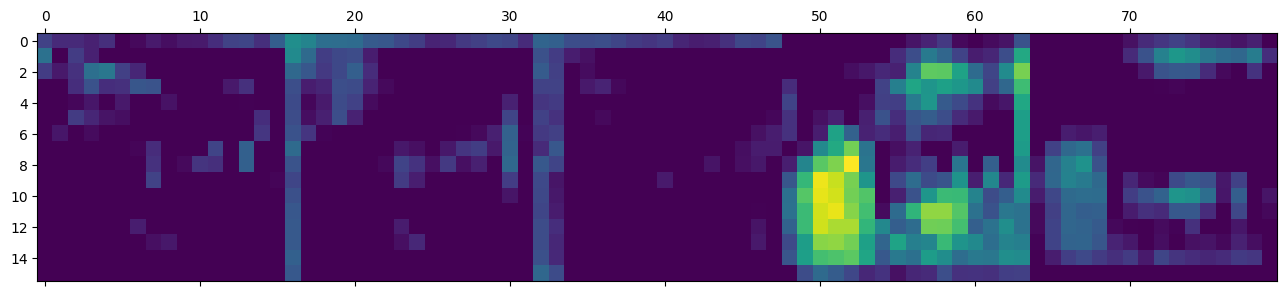

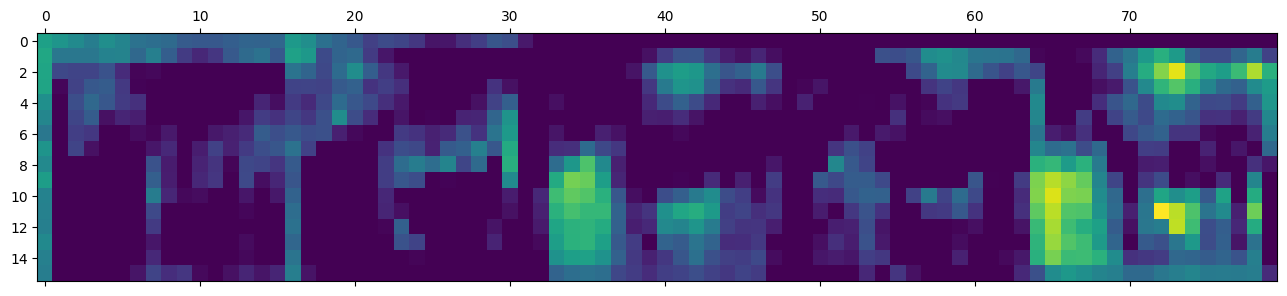

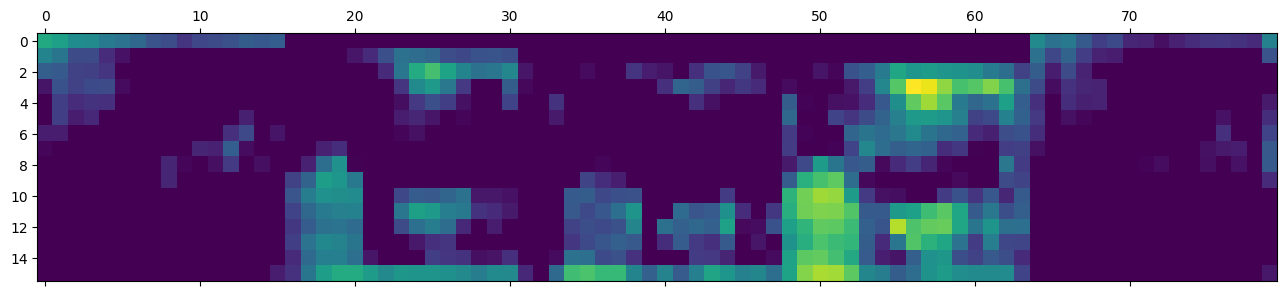

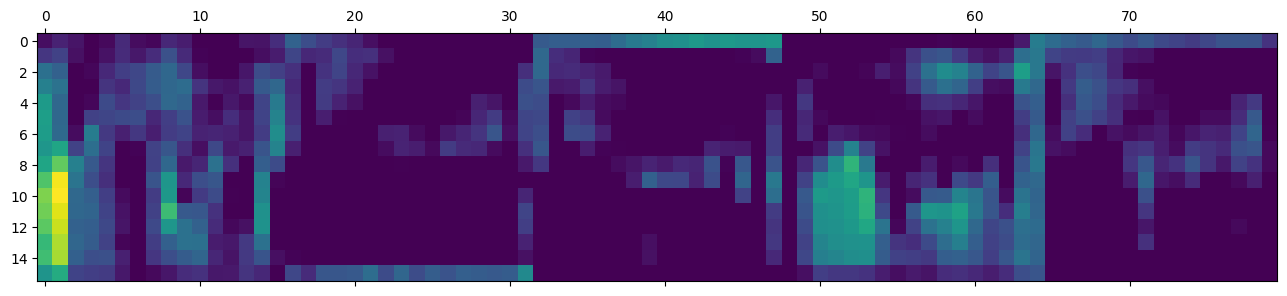

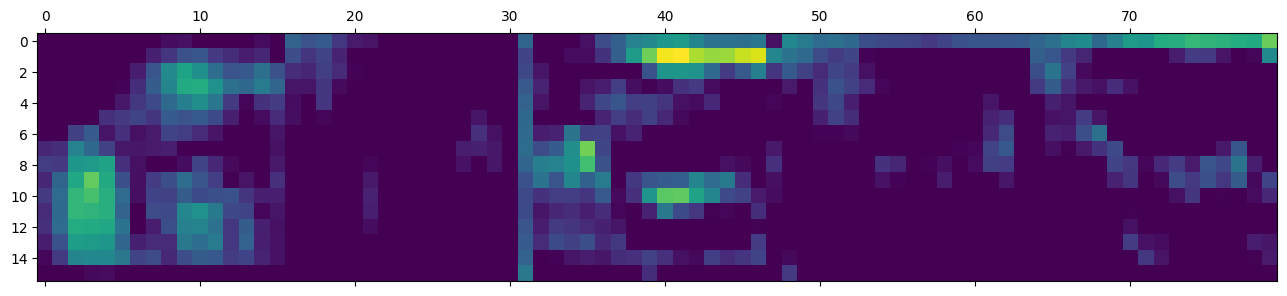

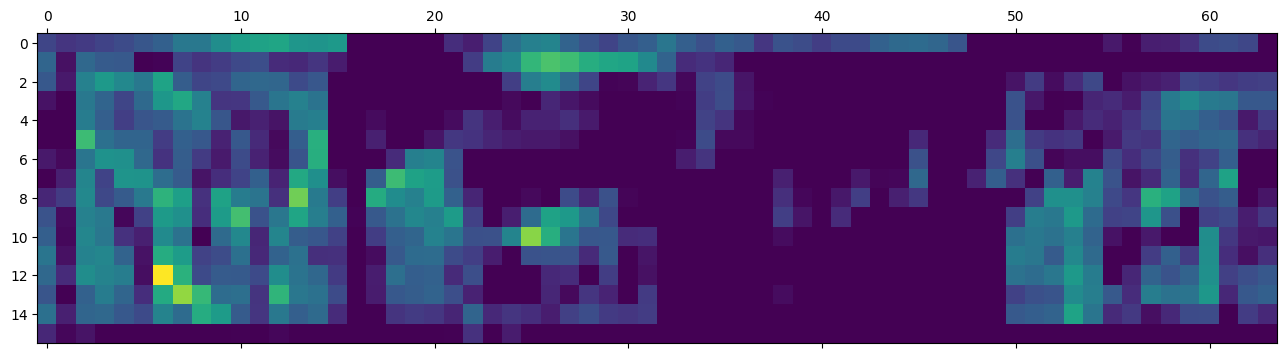

In [ ]:
i=0
for activation in activations[:5]:

  _,_,_,kernels = activation.shape
  temp = []
  for k in range(kernels):
    #print(activation[0, :, :, k])
    temp.append(activation[0, :, :, k])
  temp = split_images_into_batches(temp, 5)
  for batch in temp:
    pl = np.concatenate(tuple(batch), axis=1)
    plt.matshow(pl, cmap ='viridis')

  i+=1
  print(i, activation.shape)
  # for j in range(n):
  #   i+=1
  #   print(i, activation.shape)
  #   #temp += (activation[0, :, :, j])
  # #
  # #